In [ ]:
"""
File Name: ex5_cae_anamaly_detector_v2_cbc.ipynb

Description: anomaly detection using cae_sd for statistical features

Author: junghwan lee
Email: jhrrlee@gmail.com
Date Created: 2023.10.14
"""

In [1]:
import importlib
import sys
#from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-03-06 01:12:19.667965: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 01:12:19.932823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 01:12:27.089598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-03-06 01:12:42.572714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:42.572933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:42.805520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:42.805577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:42.805601: I external/local_xla/xla/stream_executor

In [ ]:
"""
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/dnn_models/')
data_path = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/resource/dataset/'
base_dir = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/preprocessing/cae/'
"""


In [3]:
sys.path.append('../')
sys.path.append('../../../auto_encoder/')
gen_path = '../../../resource/dataset/'
base_dir = './cae_sd/'

In [4]:
from cae_sd import create_cae_sd

In [5]:
import AnomalyDetector as AD

In [6]:
from AnomalyDetector import BatData, AutoencoderTrainer, AnomalyDetector

In [7]:
importlib.reload(AD)

<module 'AnomalyDetector' from '/mnt/d/sandbox/optimal_rul/data_analysis/p3_anomaly_detection/ex12/../AnomalyDetector.py'>

In [8]:
eol = np.load(gen_path + 'eol_21_120.npy')
cycle_sum = np.load(gen_path + 'new_cycle_sum_21_120.npy')

In [9]:
num_cells = cycle_sum.shape[0]
num_cycles = cycle_sum.shape[2]

cycle_count = np.arange(1, num_cycles+1)

# Repeat the EOL values for each cycle in the cycle_count array
eol_repeated = np.tile(eol, (1, num_cycles))

# Repeat the cycle_count values for each cell in the cycle_count array
cycle_count_repeated = np.tile(cycle_count, (num_cells, 1))

RUL_repeated = eol_repeated - cycle_count_repeated

print("RUL_repeated shape:", RUL_repeated.shape)
print("eol shape:", eol_repeated.shape)
print("cycle_count shape:", cycle_count_repeated.shape)
print("cycle_sum shape:", cycle_sum.shape)

RUL_repeated shape: (124, 100)
eol shape: (124, 100)
cycle_count shape: (124, 100)
cycle_sum shape: (124, 14, 100)


In [10]:
import tensorflow as tf
def mape(y_true, y_pred):
    epsilon = 1e-9  # Adding a small constant to avoid division by zero
    error = (y_true - y_pred) / (tf.abs(y_true) + epsilon)
    return 100.0 * tf.reduce_mean(tf.abs(error))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


In [11]:
reshaped_cycle_sum = cycle_sum.transpose(0, 2, 1).reshape(124, 100, 14, 1)

In [12]:
reshaped_cycle_sum.shape

(124, 100, 14, 1)

In [13]:
batdata = BatData(reshaped_cycle_sum)

In [14]:
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

2025-03-06 01:12:44.500590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:44.500723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:44.500760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:44.500781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:12:44.500800: I external/local_xla/xla/stream_executor

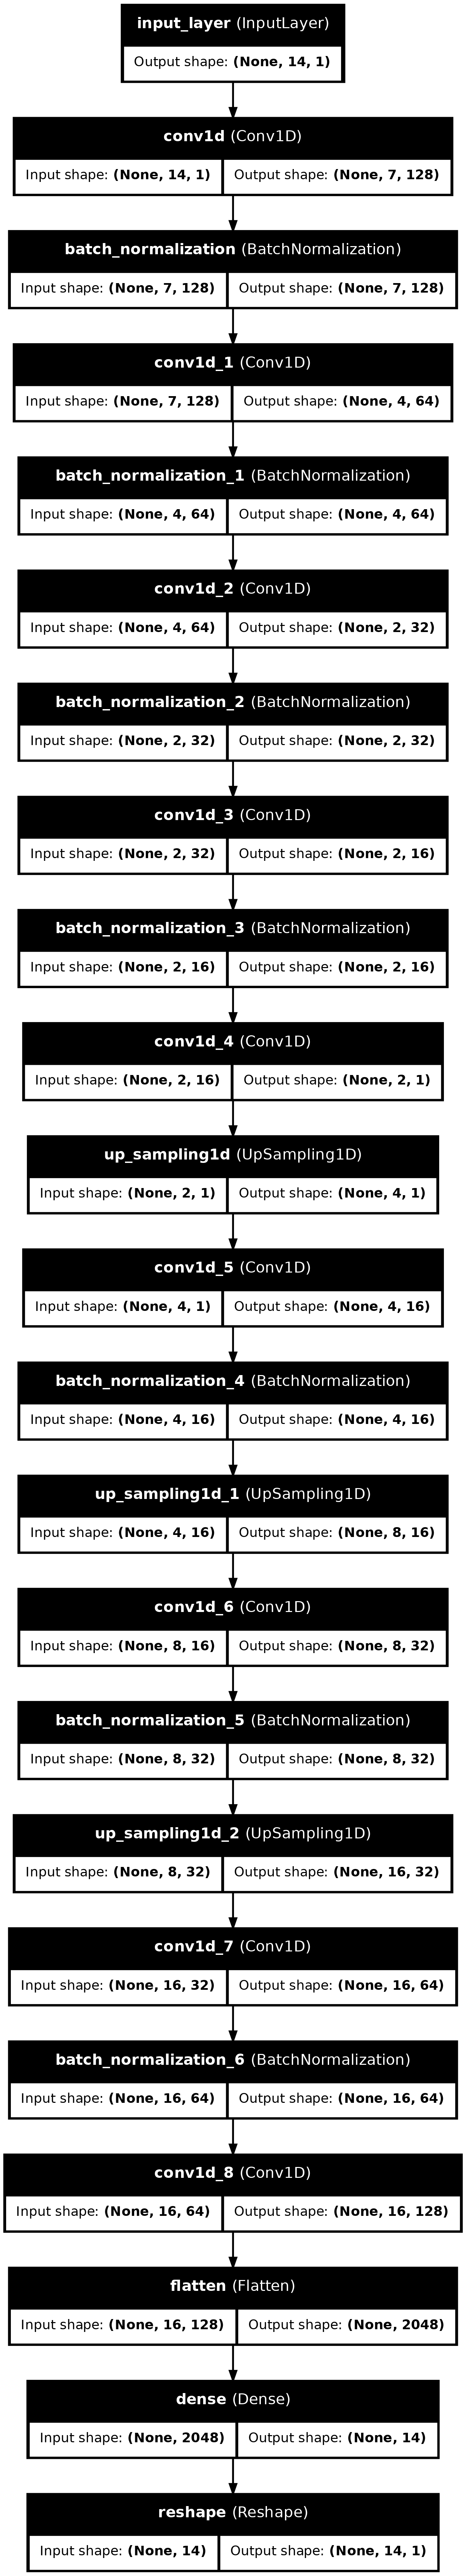

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(cae_sd_model, to_file='cae_sd_model.png', show_shapes=True, show_layer_names=True)

In [36]:
cae_sd_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 7, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 2, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 2, 1)           │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 4, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 8, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 16, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 16, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 95,535 (373.18 KB)

 Trainable params: 94,831 (370.43 KB)

 Non-trainable params: 704 (2.75 KB)

In [17]:
cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model', batdata, cae_sd_model)

In [16]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=1, max_epoch=300, no_patience=100)

  0%|          | 0/300 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1740359835.198256  468604 service.cc:145] XLA service 0x7f29dc01f4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740359835.198376  468604 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-24 10:17:15.290724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-24 10:17:15.617171: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1740359837.835277  468604 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
 61%|██████    | 183/300 [2:03:28<1:18:56, 40.48s/epoch, loss=0.00393, mae=0.0239, mape=3.29, rmse=0.049]


In [20]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.0187504291534424 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[  0   1   2   3   4   5  26  41  60  61  86  88  99 100 101 102 104 107
 108 109 110 111 115 116 117]


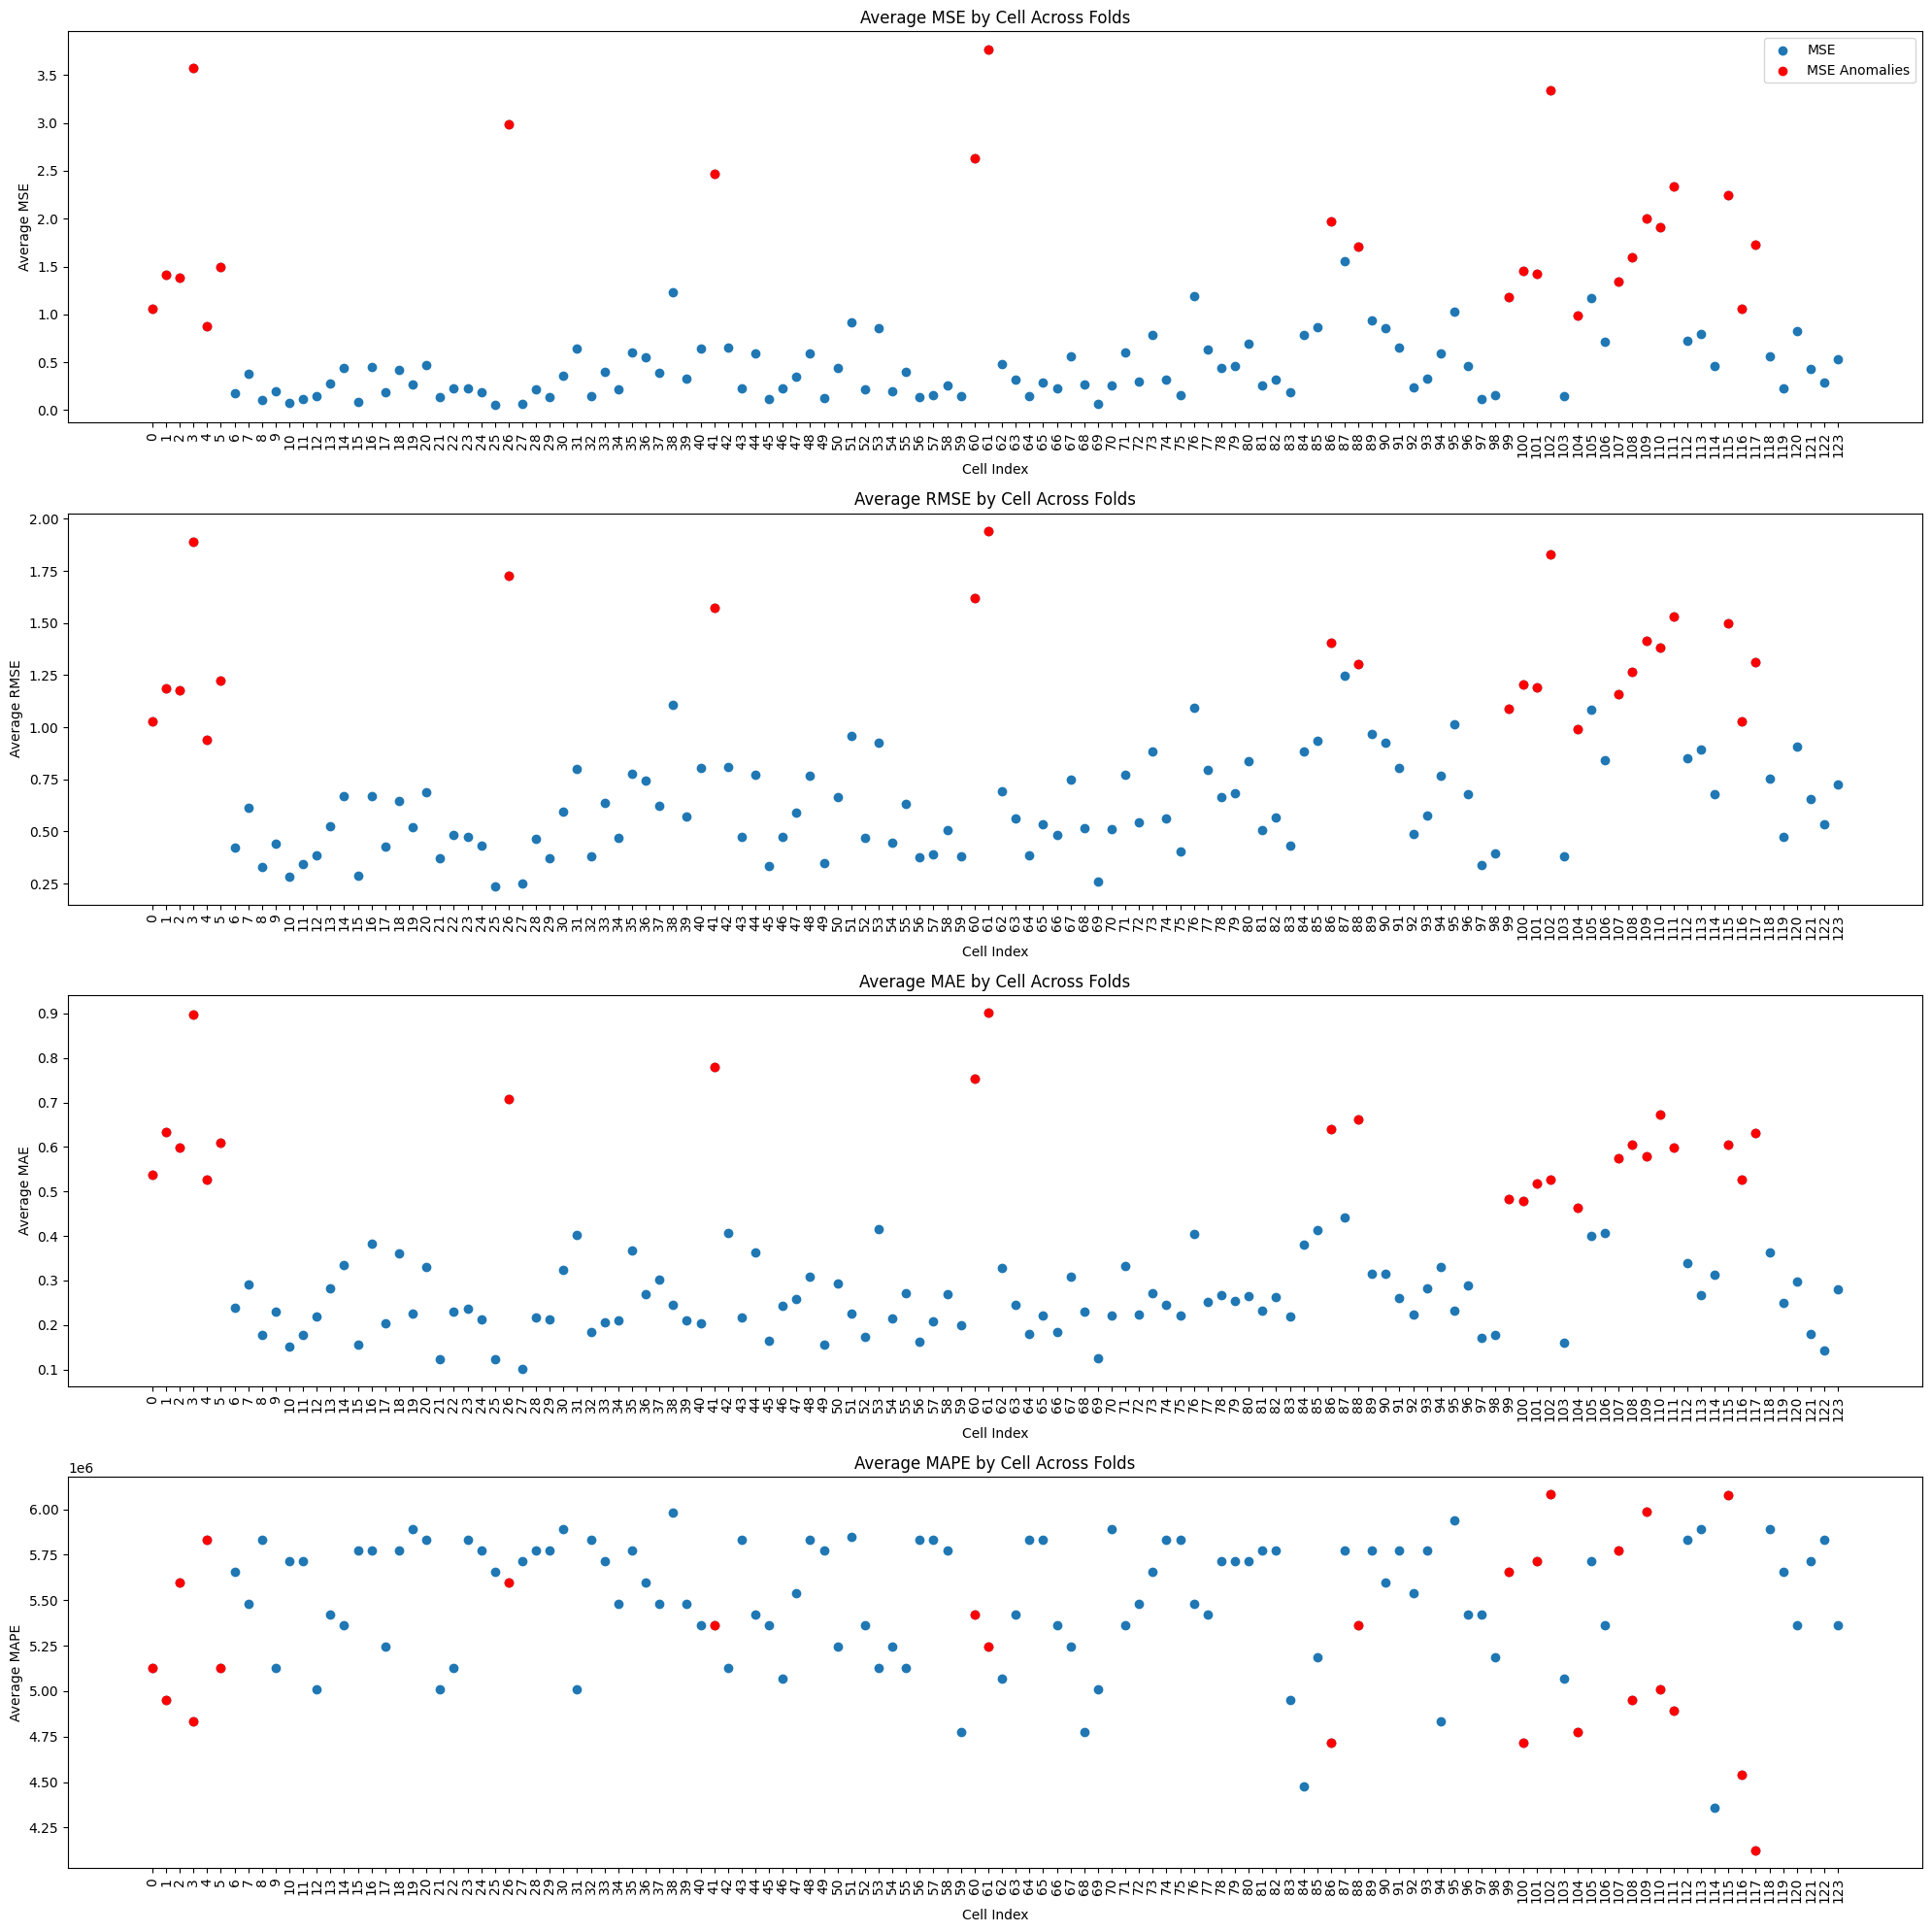

In [17]:

anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[  4   8  19  20  23  30  32  38  43  48  51  56  57  64  70  74  75  95
 102 109 112 113 115 118 122]


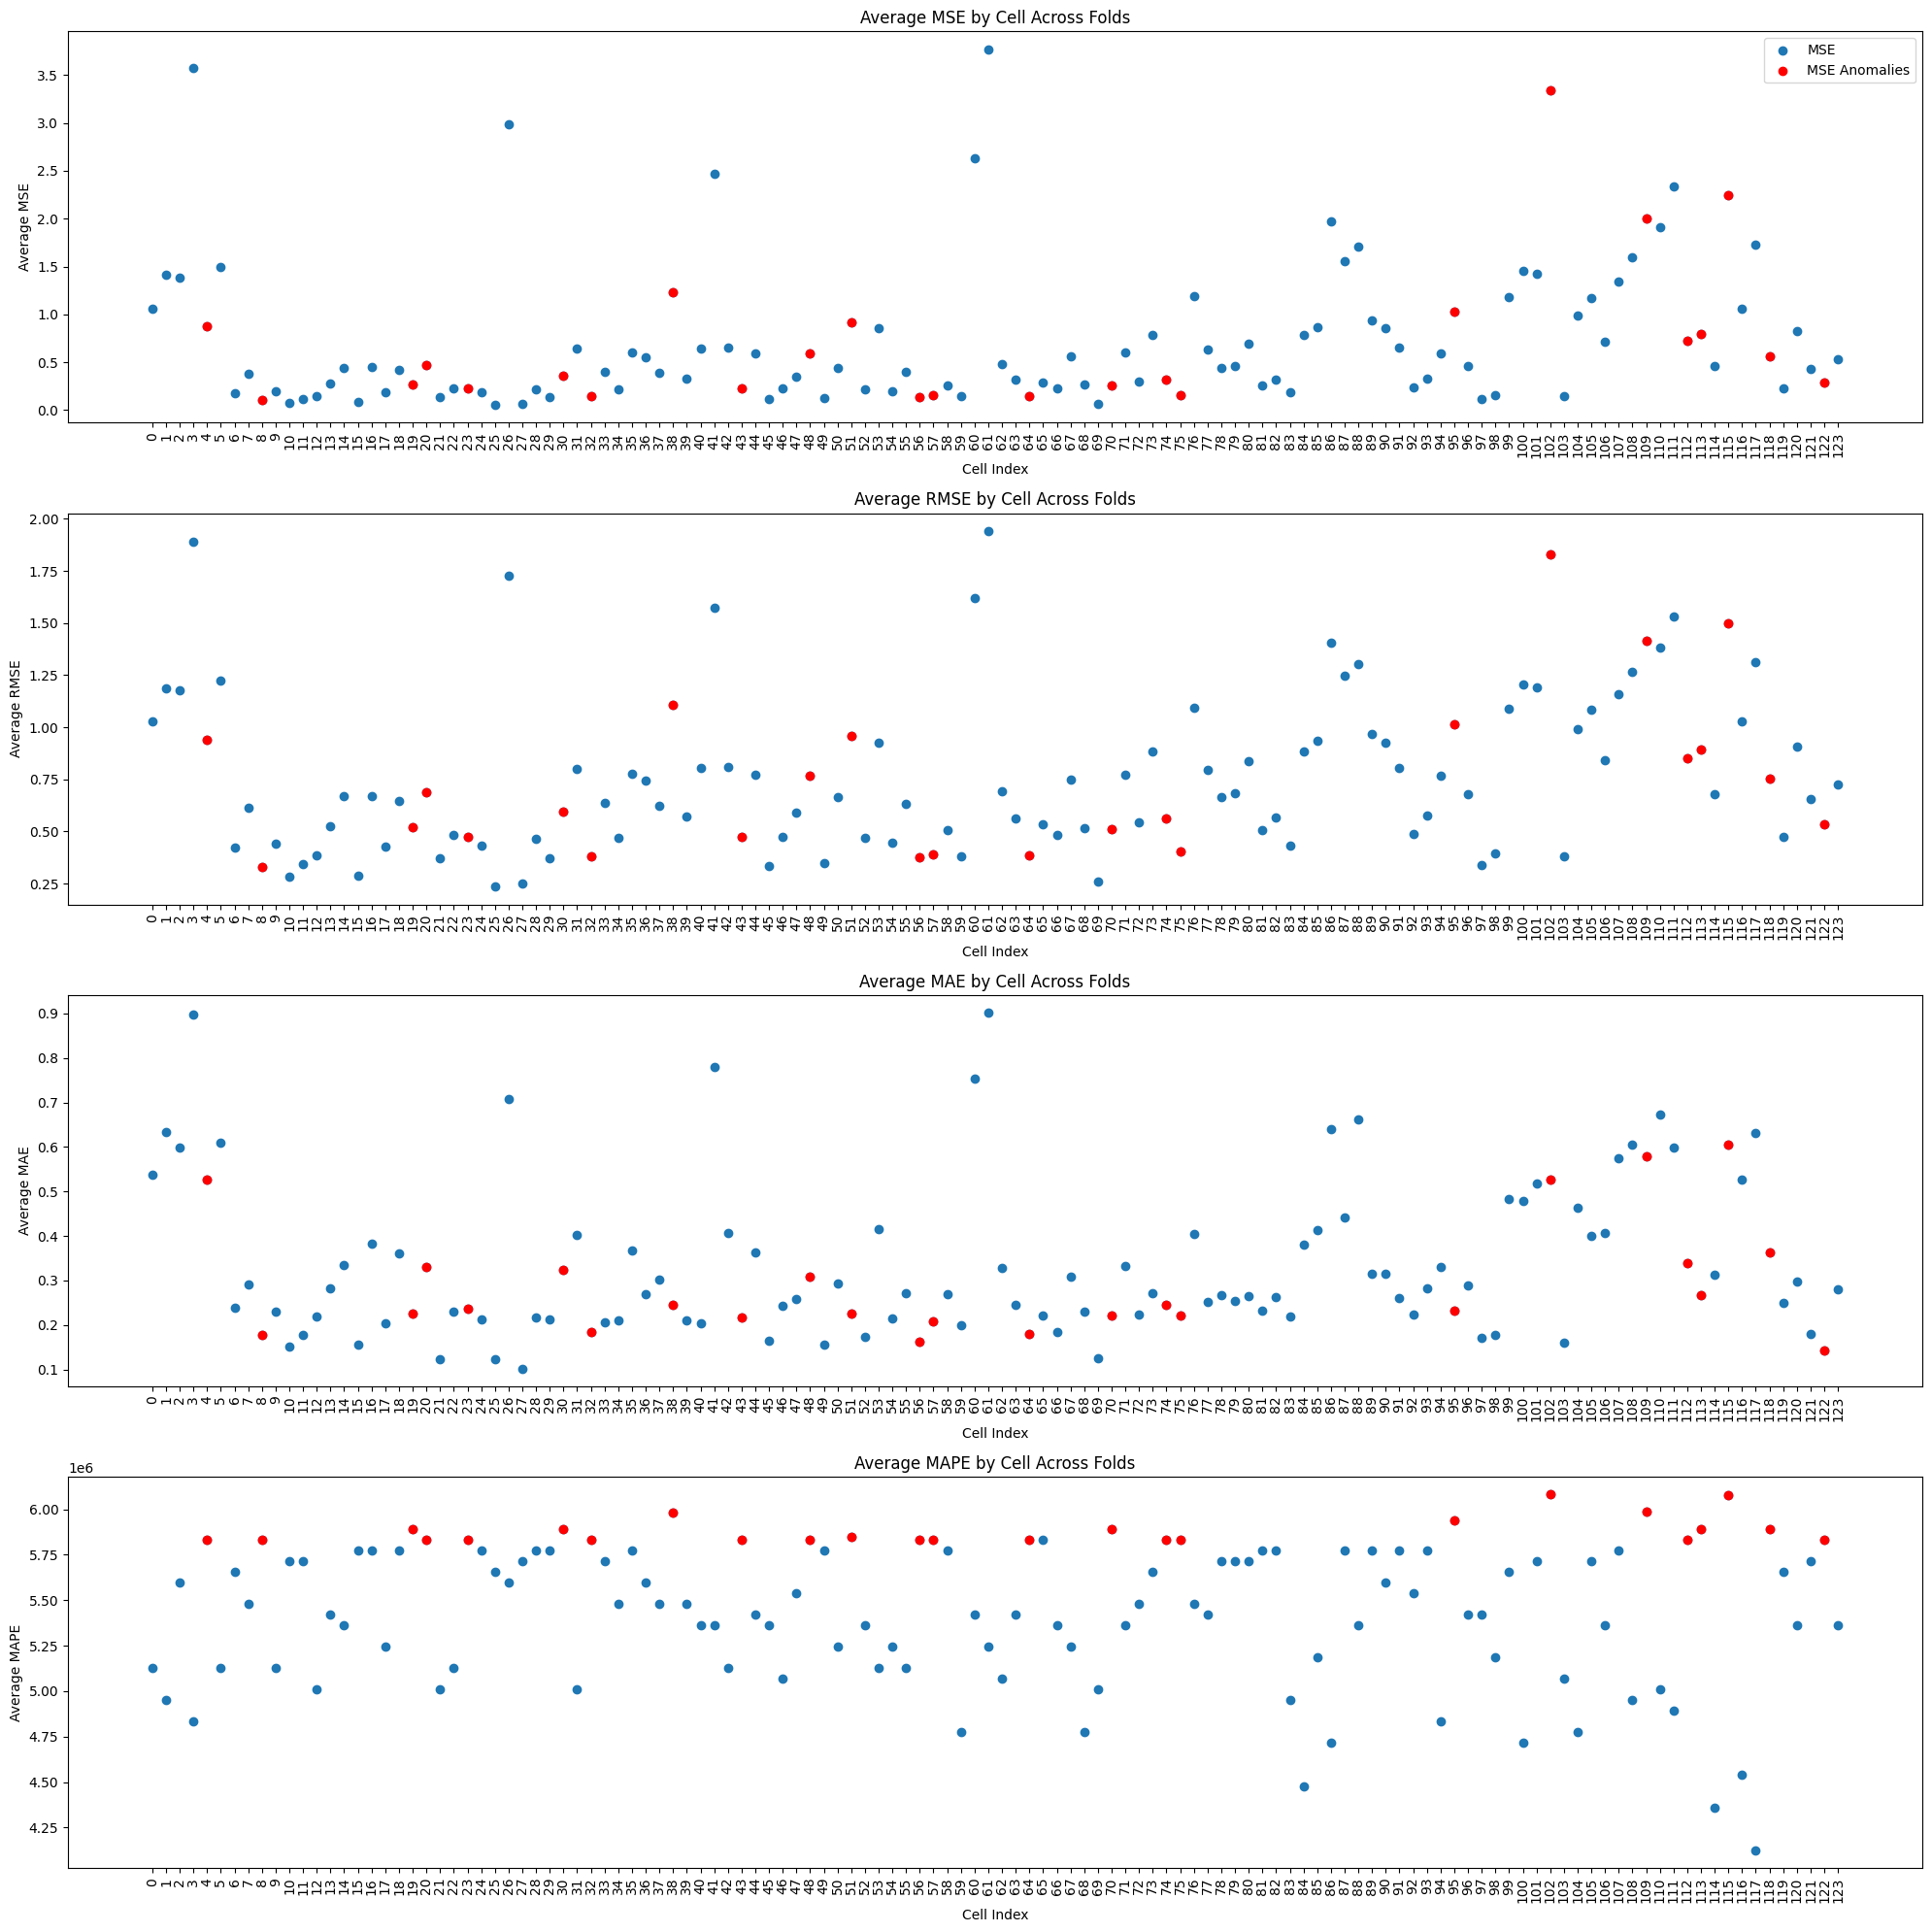

In [18]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

In [49]:
import tensorflow as tf
import gc
del cae_sd
del cae_sd_model, cae_sd_encoder
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()

0

In [50]:
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

In [51]:

cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model_t1_2', batdata, cae_sd_model)

In [52]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=1, max_epoch=300, no_patience=20)

 29%|██▊       | 86/300 [1:07:23<2:47:42, 47.02s/epoch, loss=0.00393, mae=0.0239, mape=3.29, rmse=0.0489]


388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[  0   1   2   3   4   5  26  41  60  61  86  87  88  99 100 101 102 107
 108 109 110 111 115 116 117]


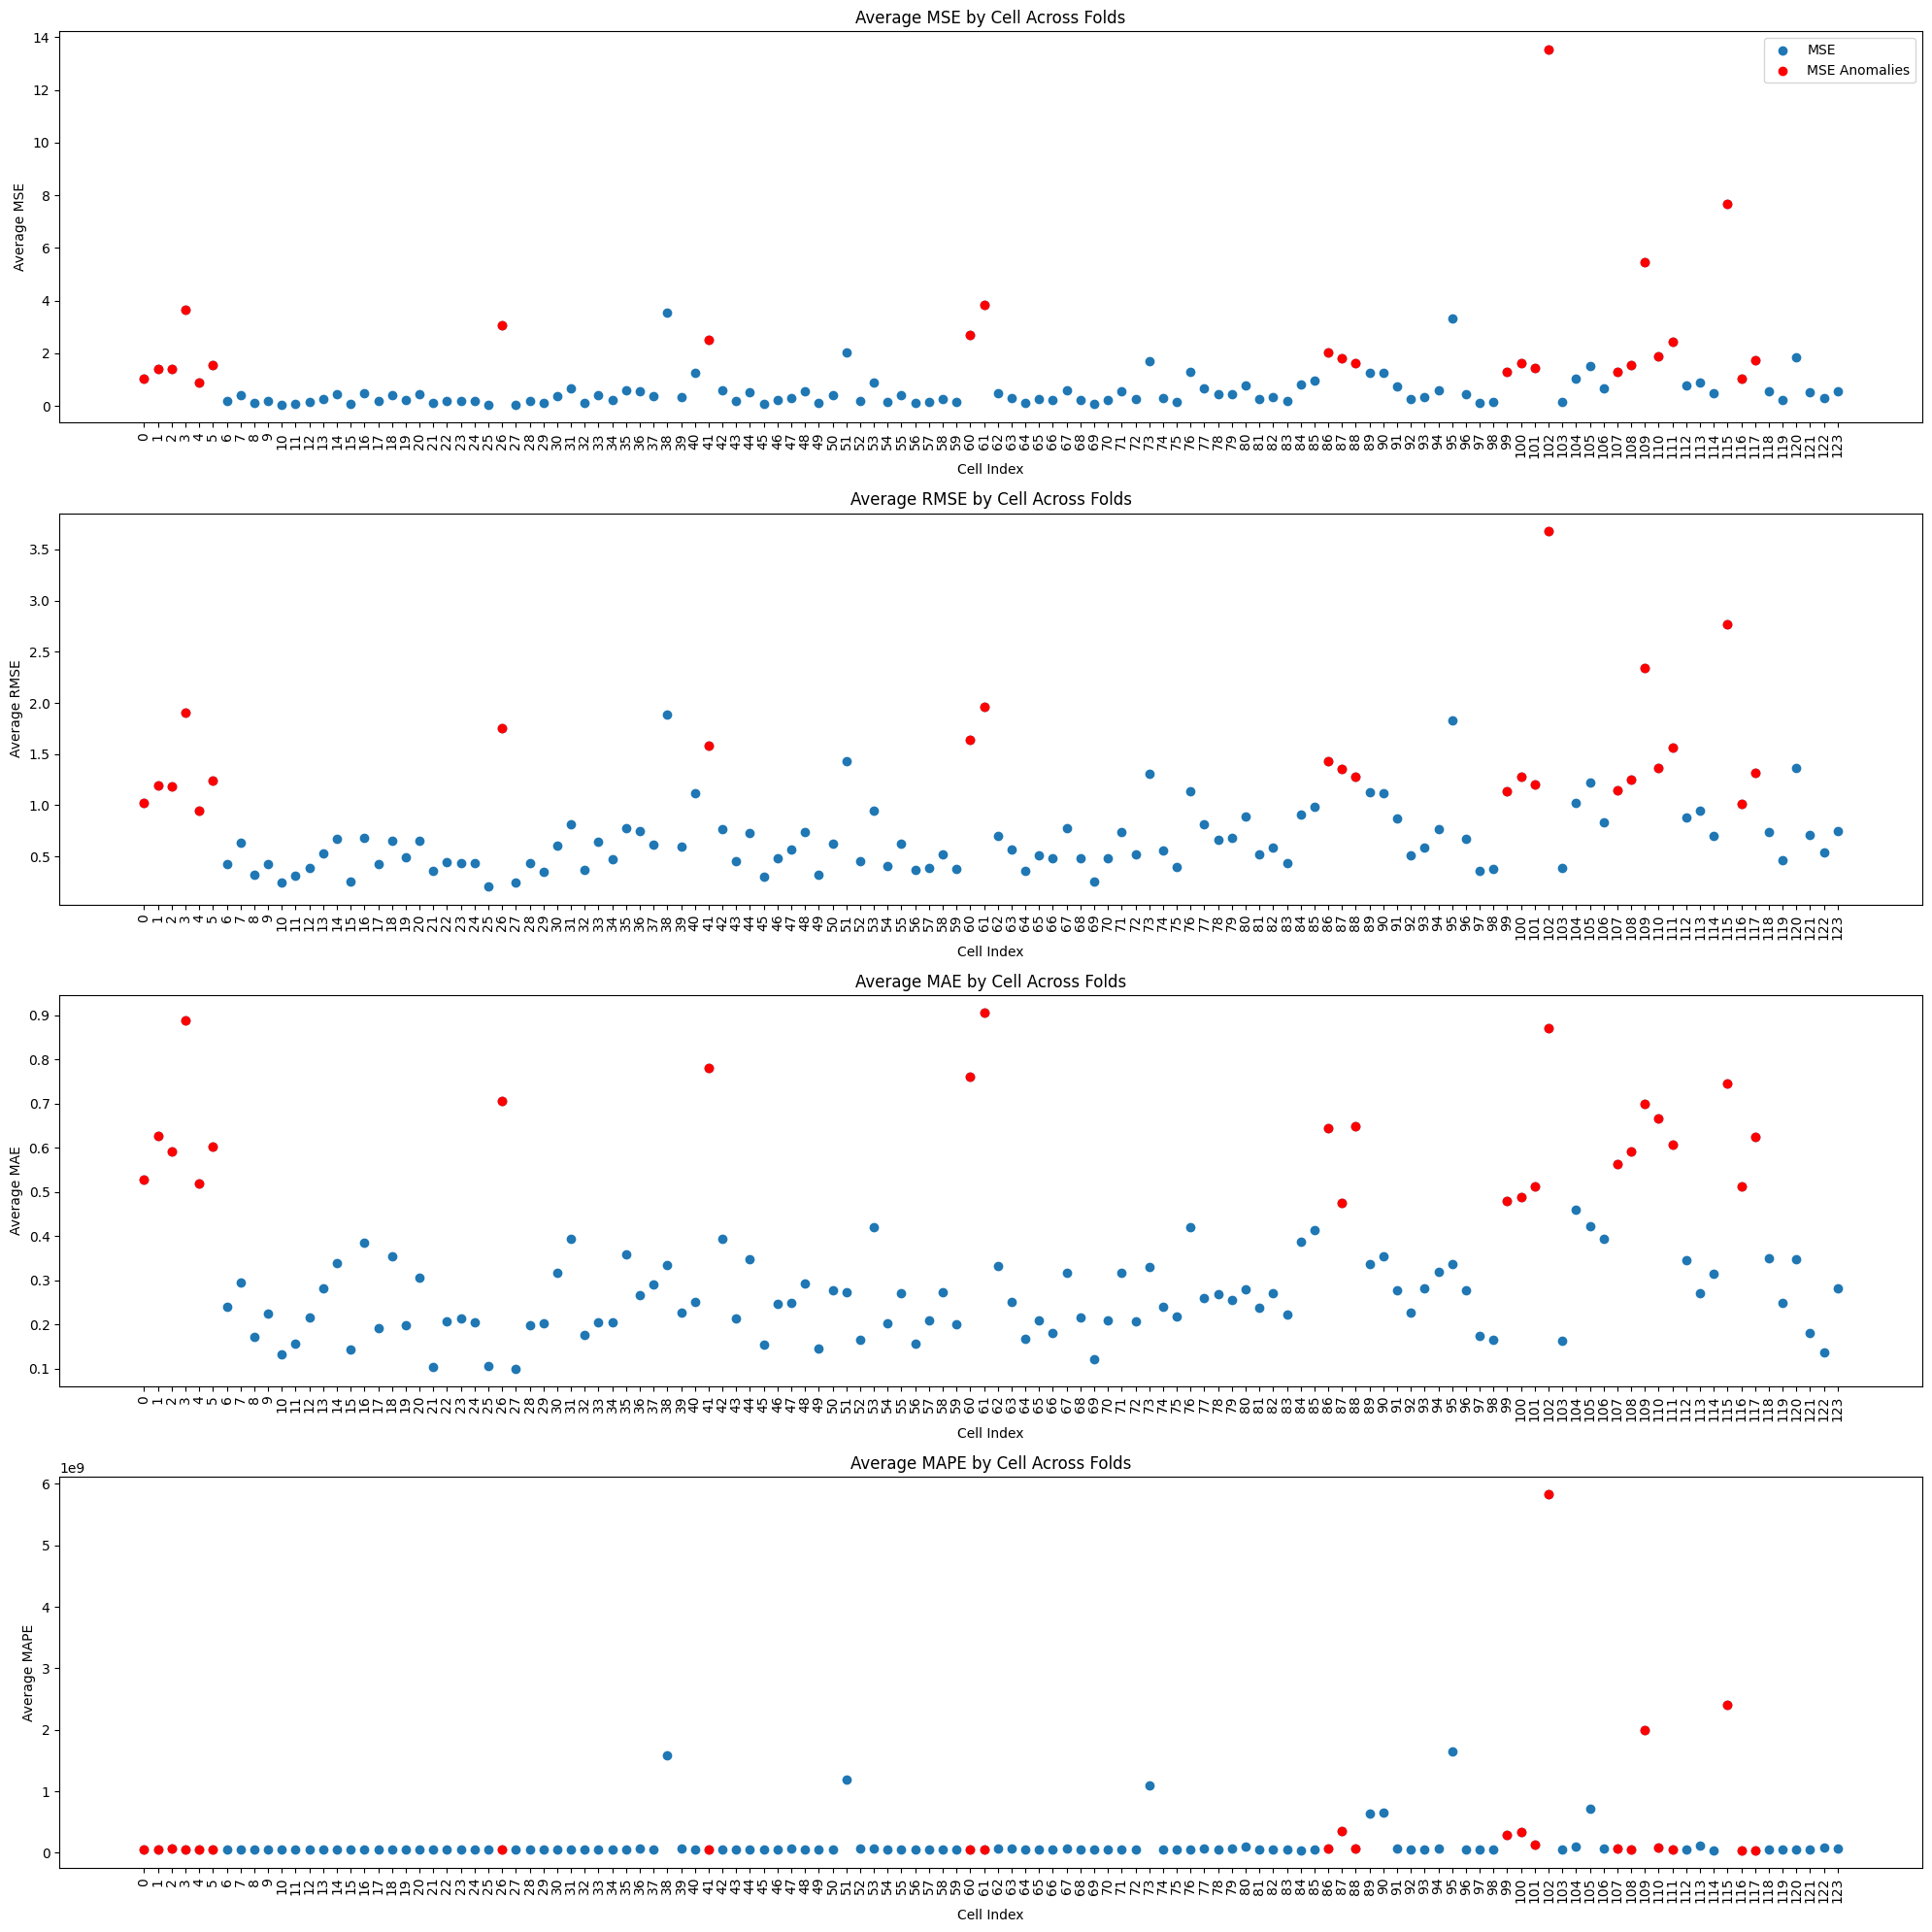

In [53]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()
anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[ 36  38  51  53  63  73  77  80  87  89  90  95  99 100 101 102 104 105
 106 107 109 110 113 115 122]


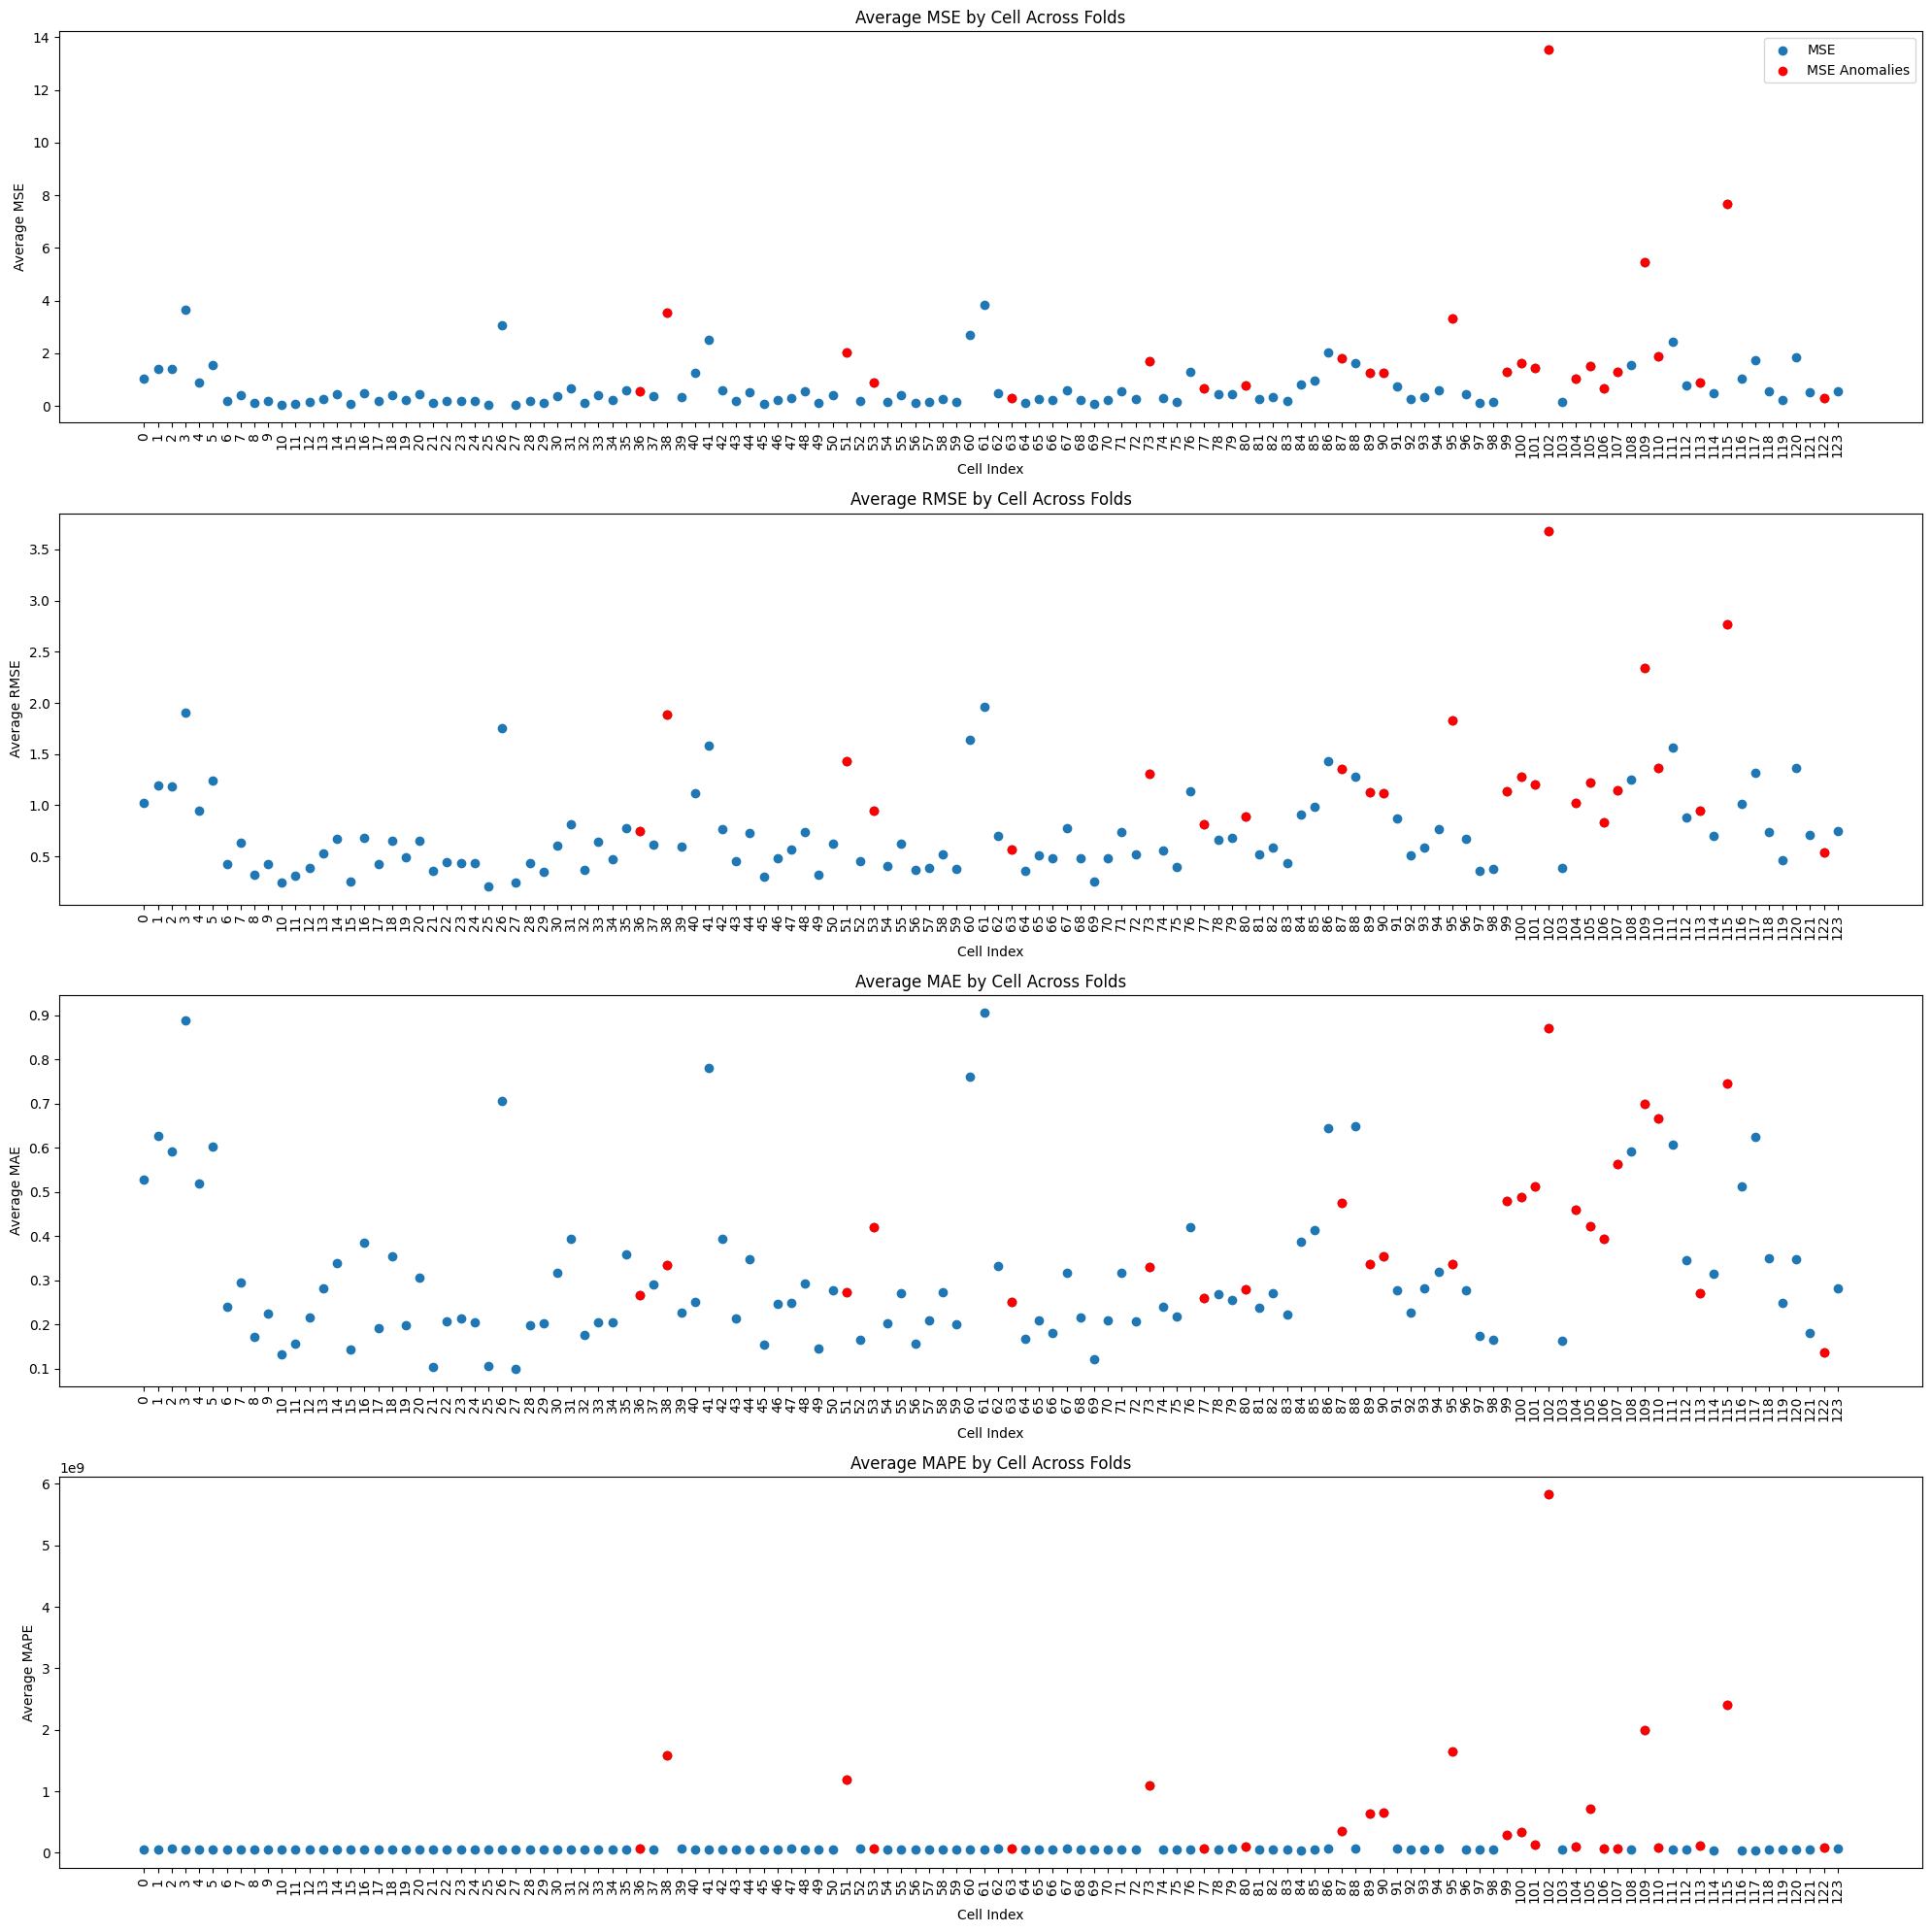

In [54]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

In [ ]:
import tensorflow as tf
import gc
del cae_sd
del cae_sd_model, cae_sd_encoder
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

In [59]:
cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model_t2', batdata, cae_sd_model)

In [60]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=2, max_epoch=300, no_patience=20)

 32%|███▏      | 95/300 [37:21<1:20:35, 23.59s/epoch, loss=0.000832, mae=0.0128, mape=2.57, rmse=0.0263]


388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[ 38  40  51  73  76  77  80  85  86  87  89  90  91  95  99 100 101 102
 104 105 109 113 115 120 121]


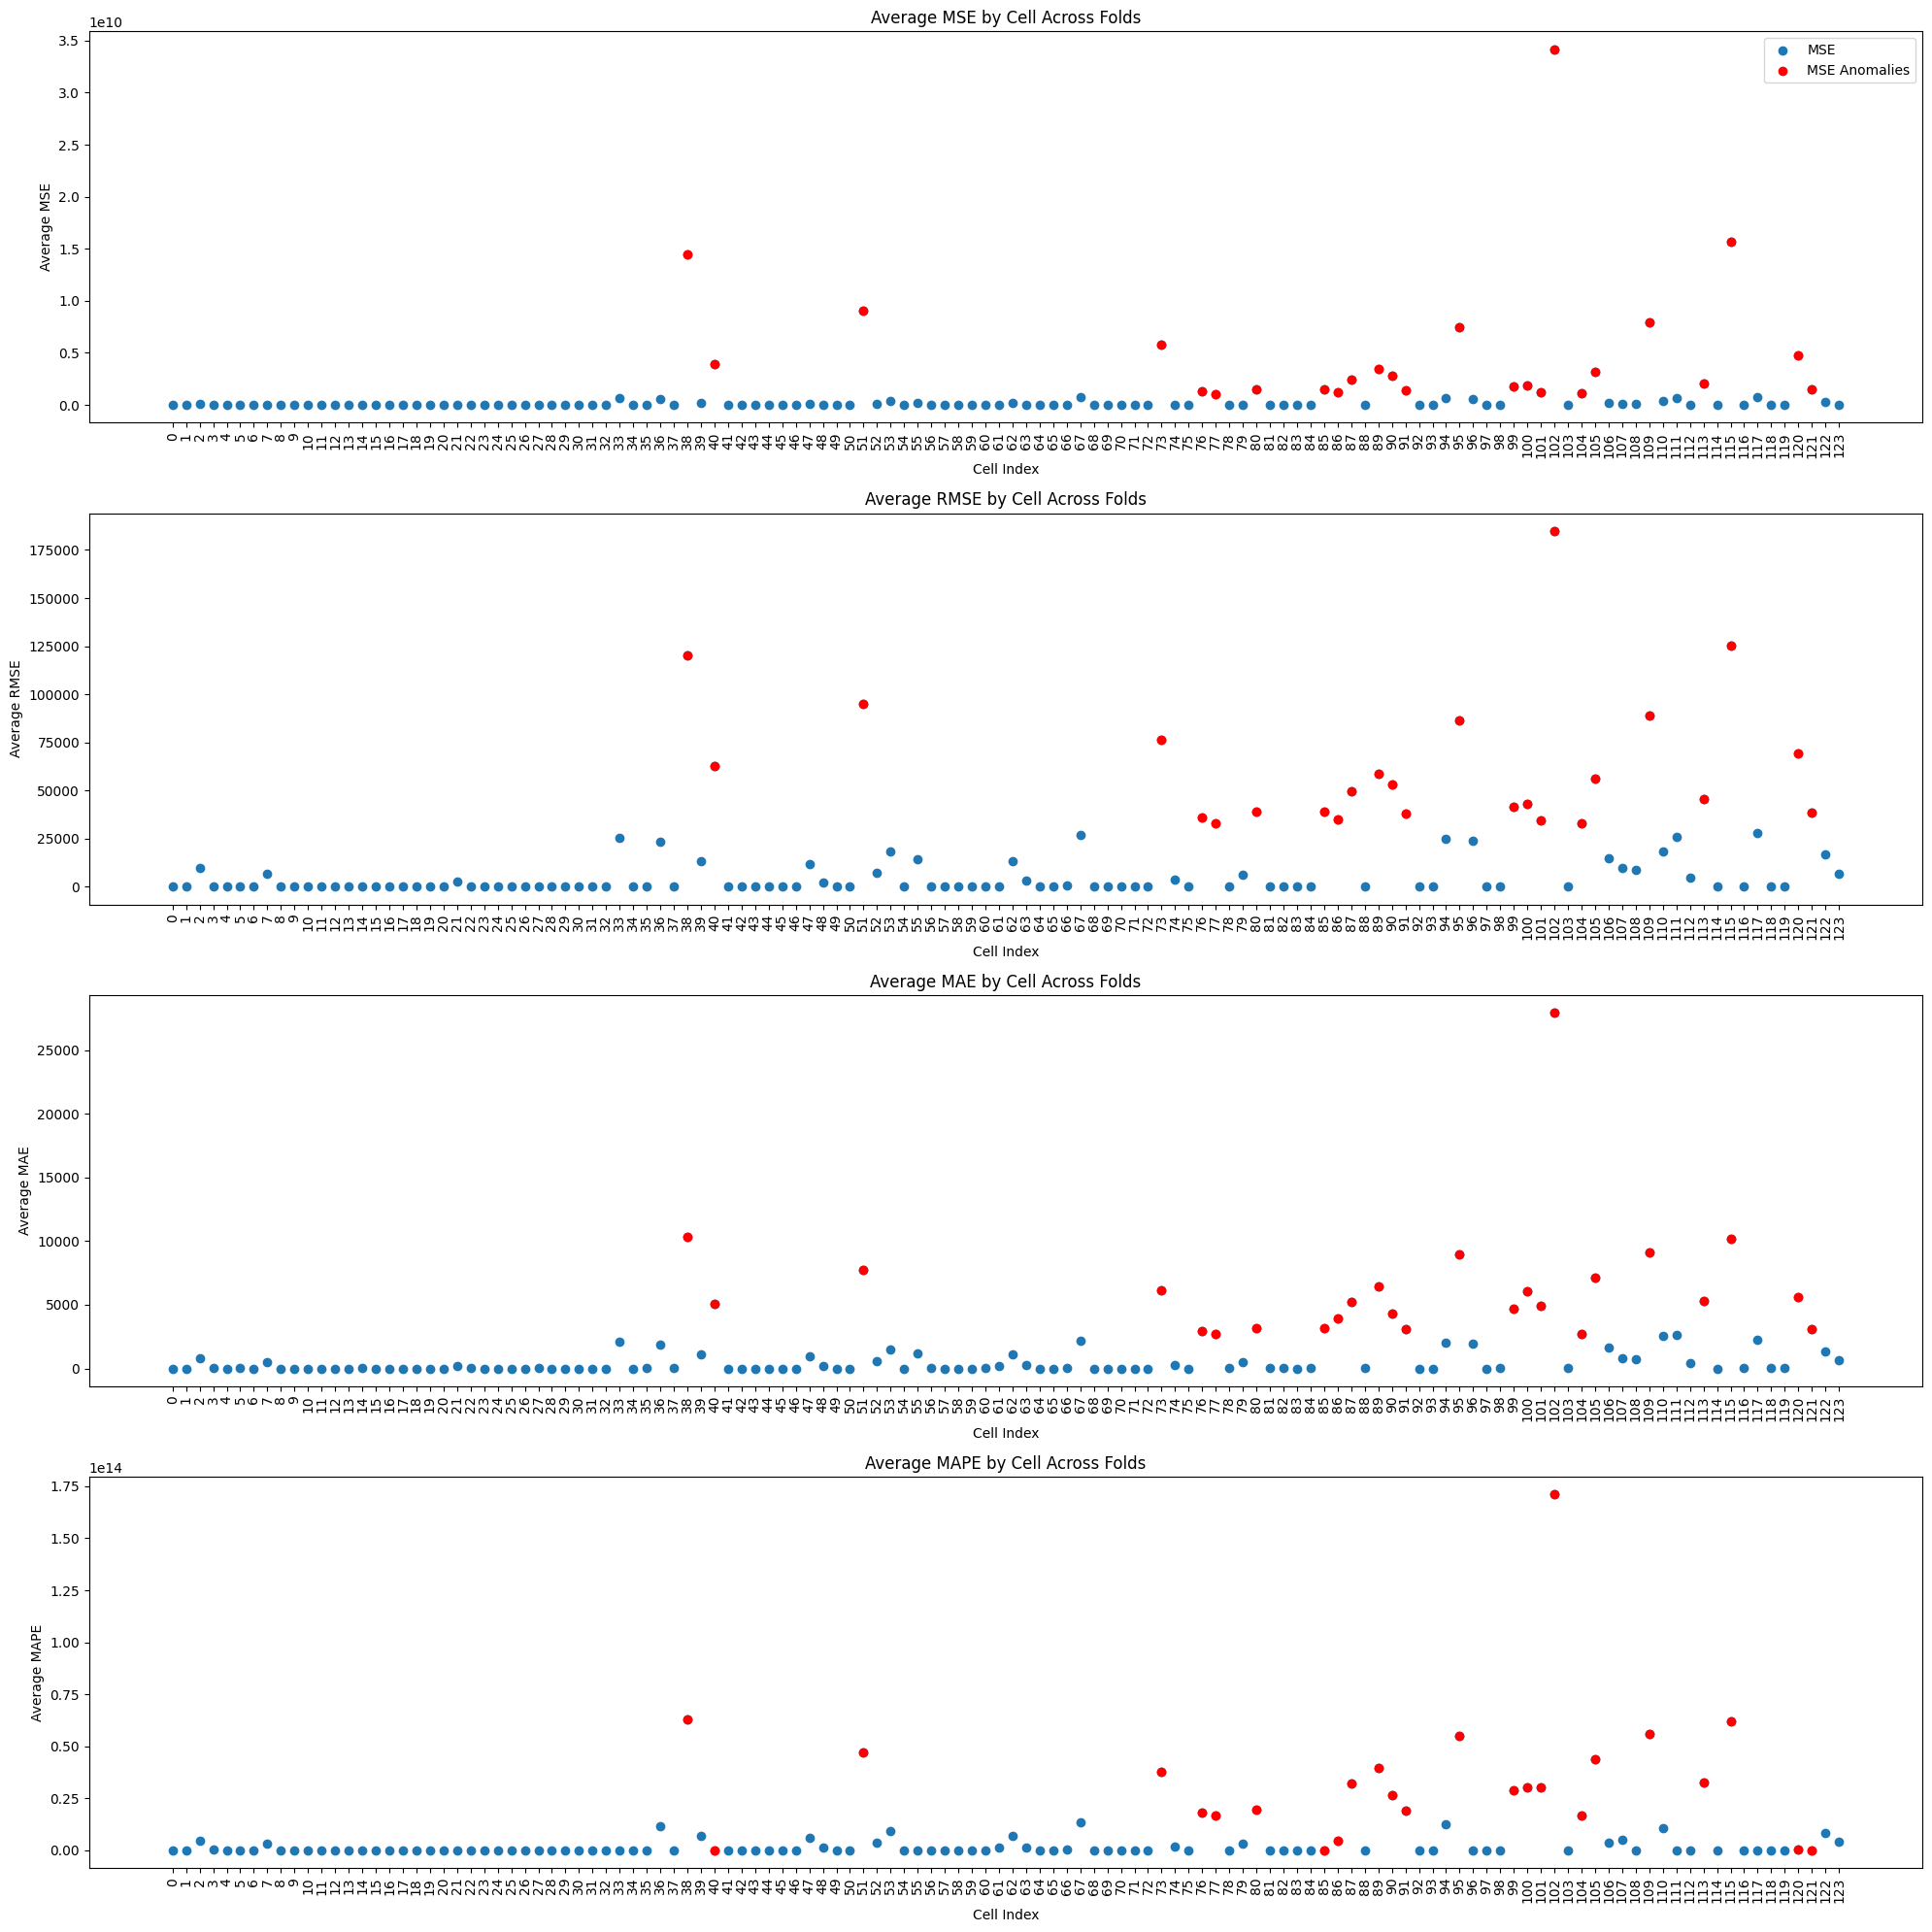

In [61]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()
anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[ 36  38  51  53  67  73  76  77  80  87  89  90  91  94  95  99 100 101
 102 104 105 109 110 113 115]


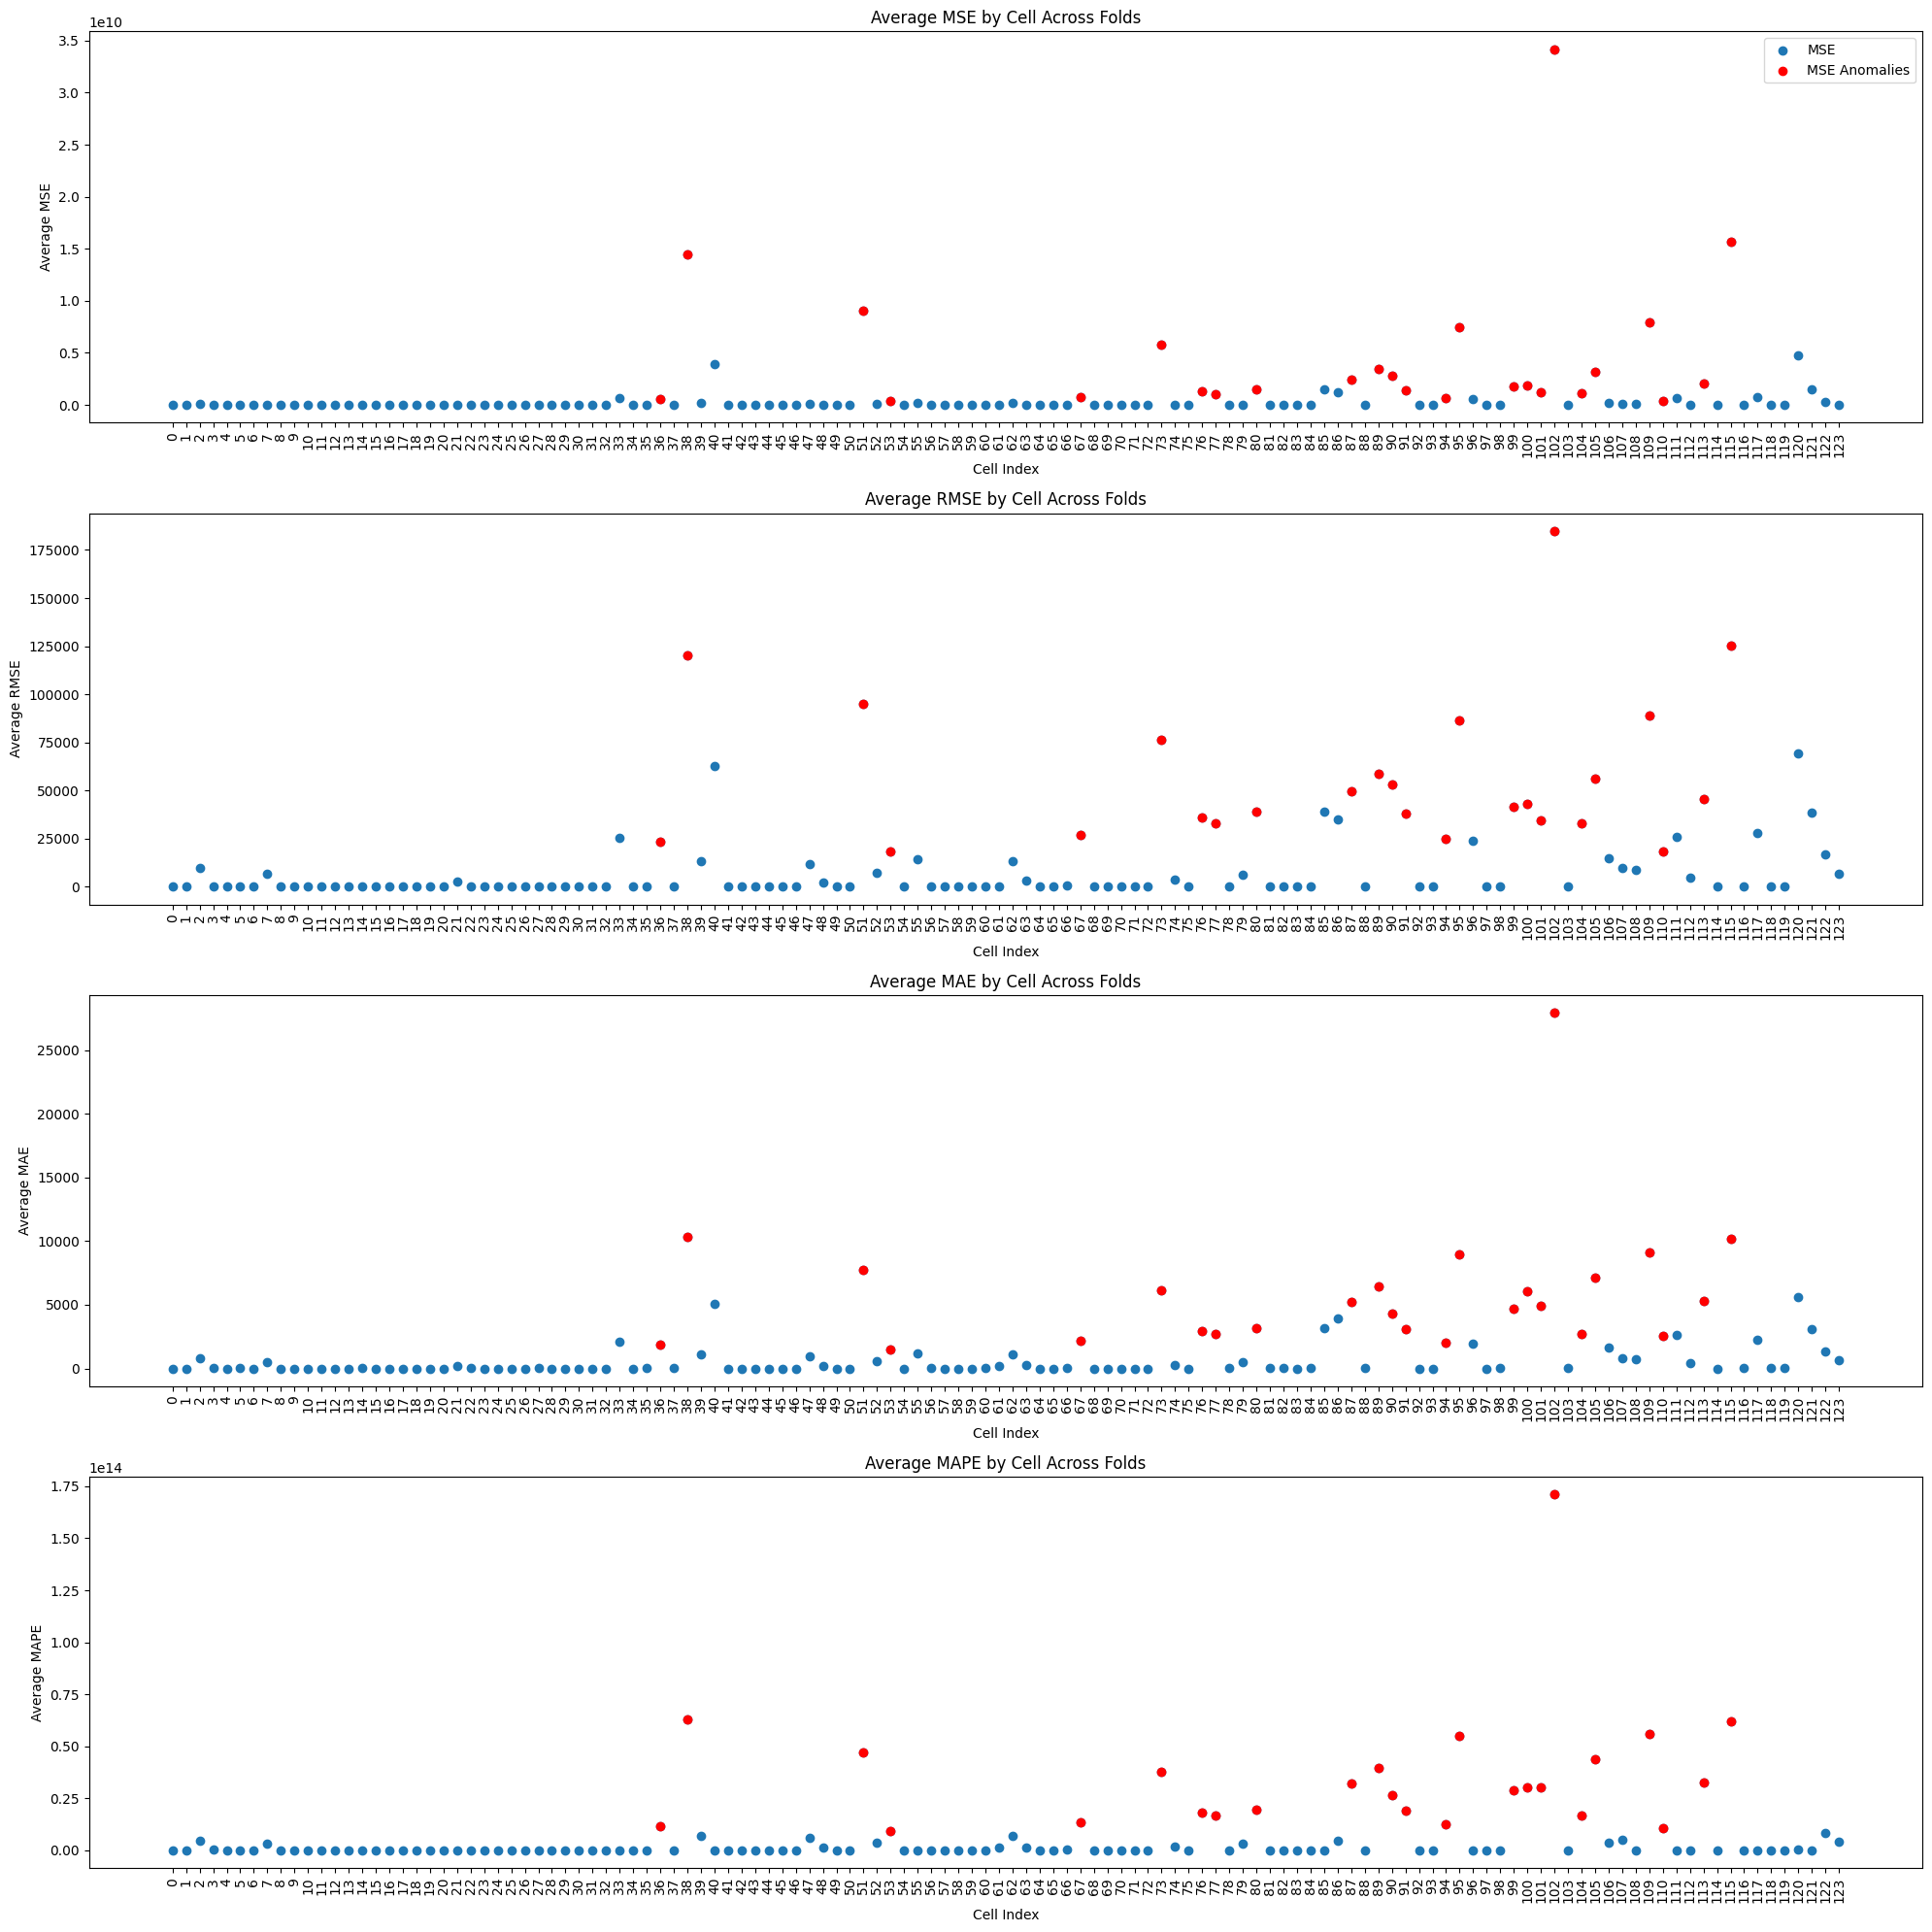

In [62]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

In [63]:
import tensorflow as tf
import gc
del cae_sd
del cae_sd_model, cae_sd_encoder
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

In [64]:
cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model_t3', batdata, cae_sd_model)

In [65]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=4, max_epoch=300, no_patience=20)

 71%|███████▏  | 214/300 [42:49<17:12, 12.01s/epoch, loss=0.000394, mae=0.00868, mape=2.07, rmse=0.0186]


388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[ 38  40  51  73  76  77  80  86  87  89  91  95  99 100 101 102 104 105
 108 109 110 111 113 115 120]


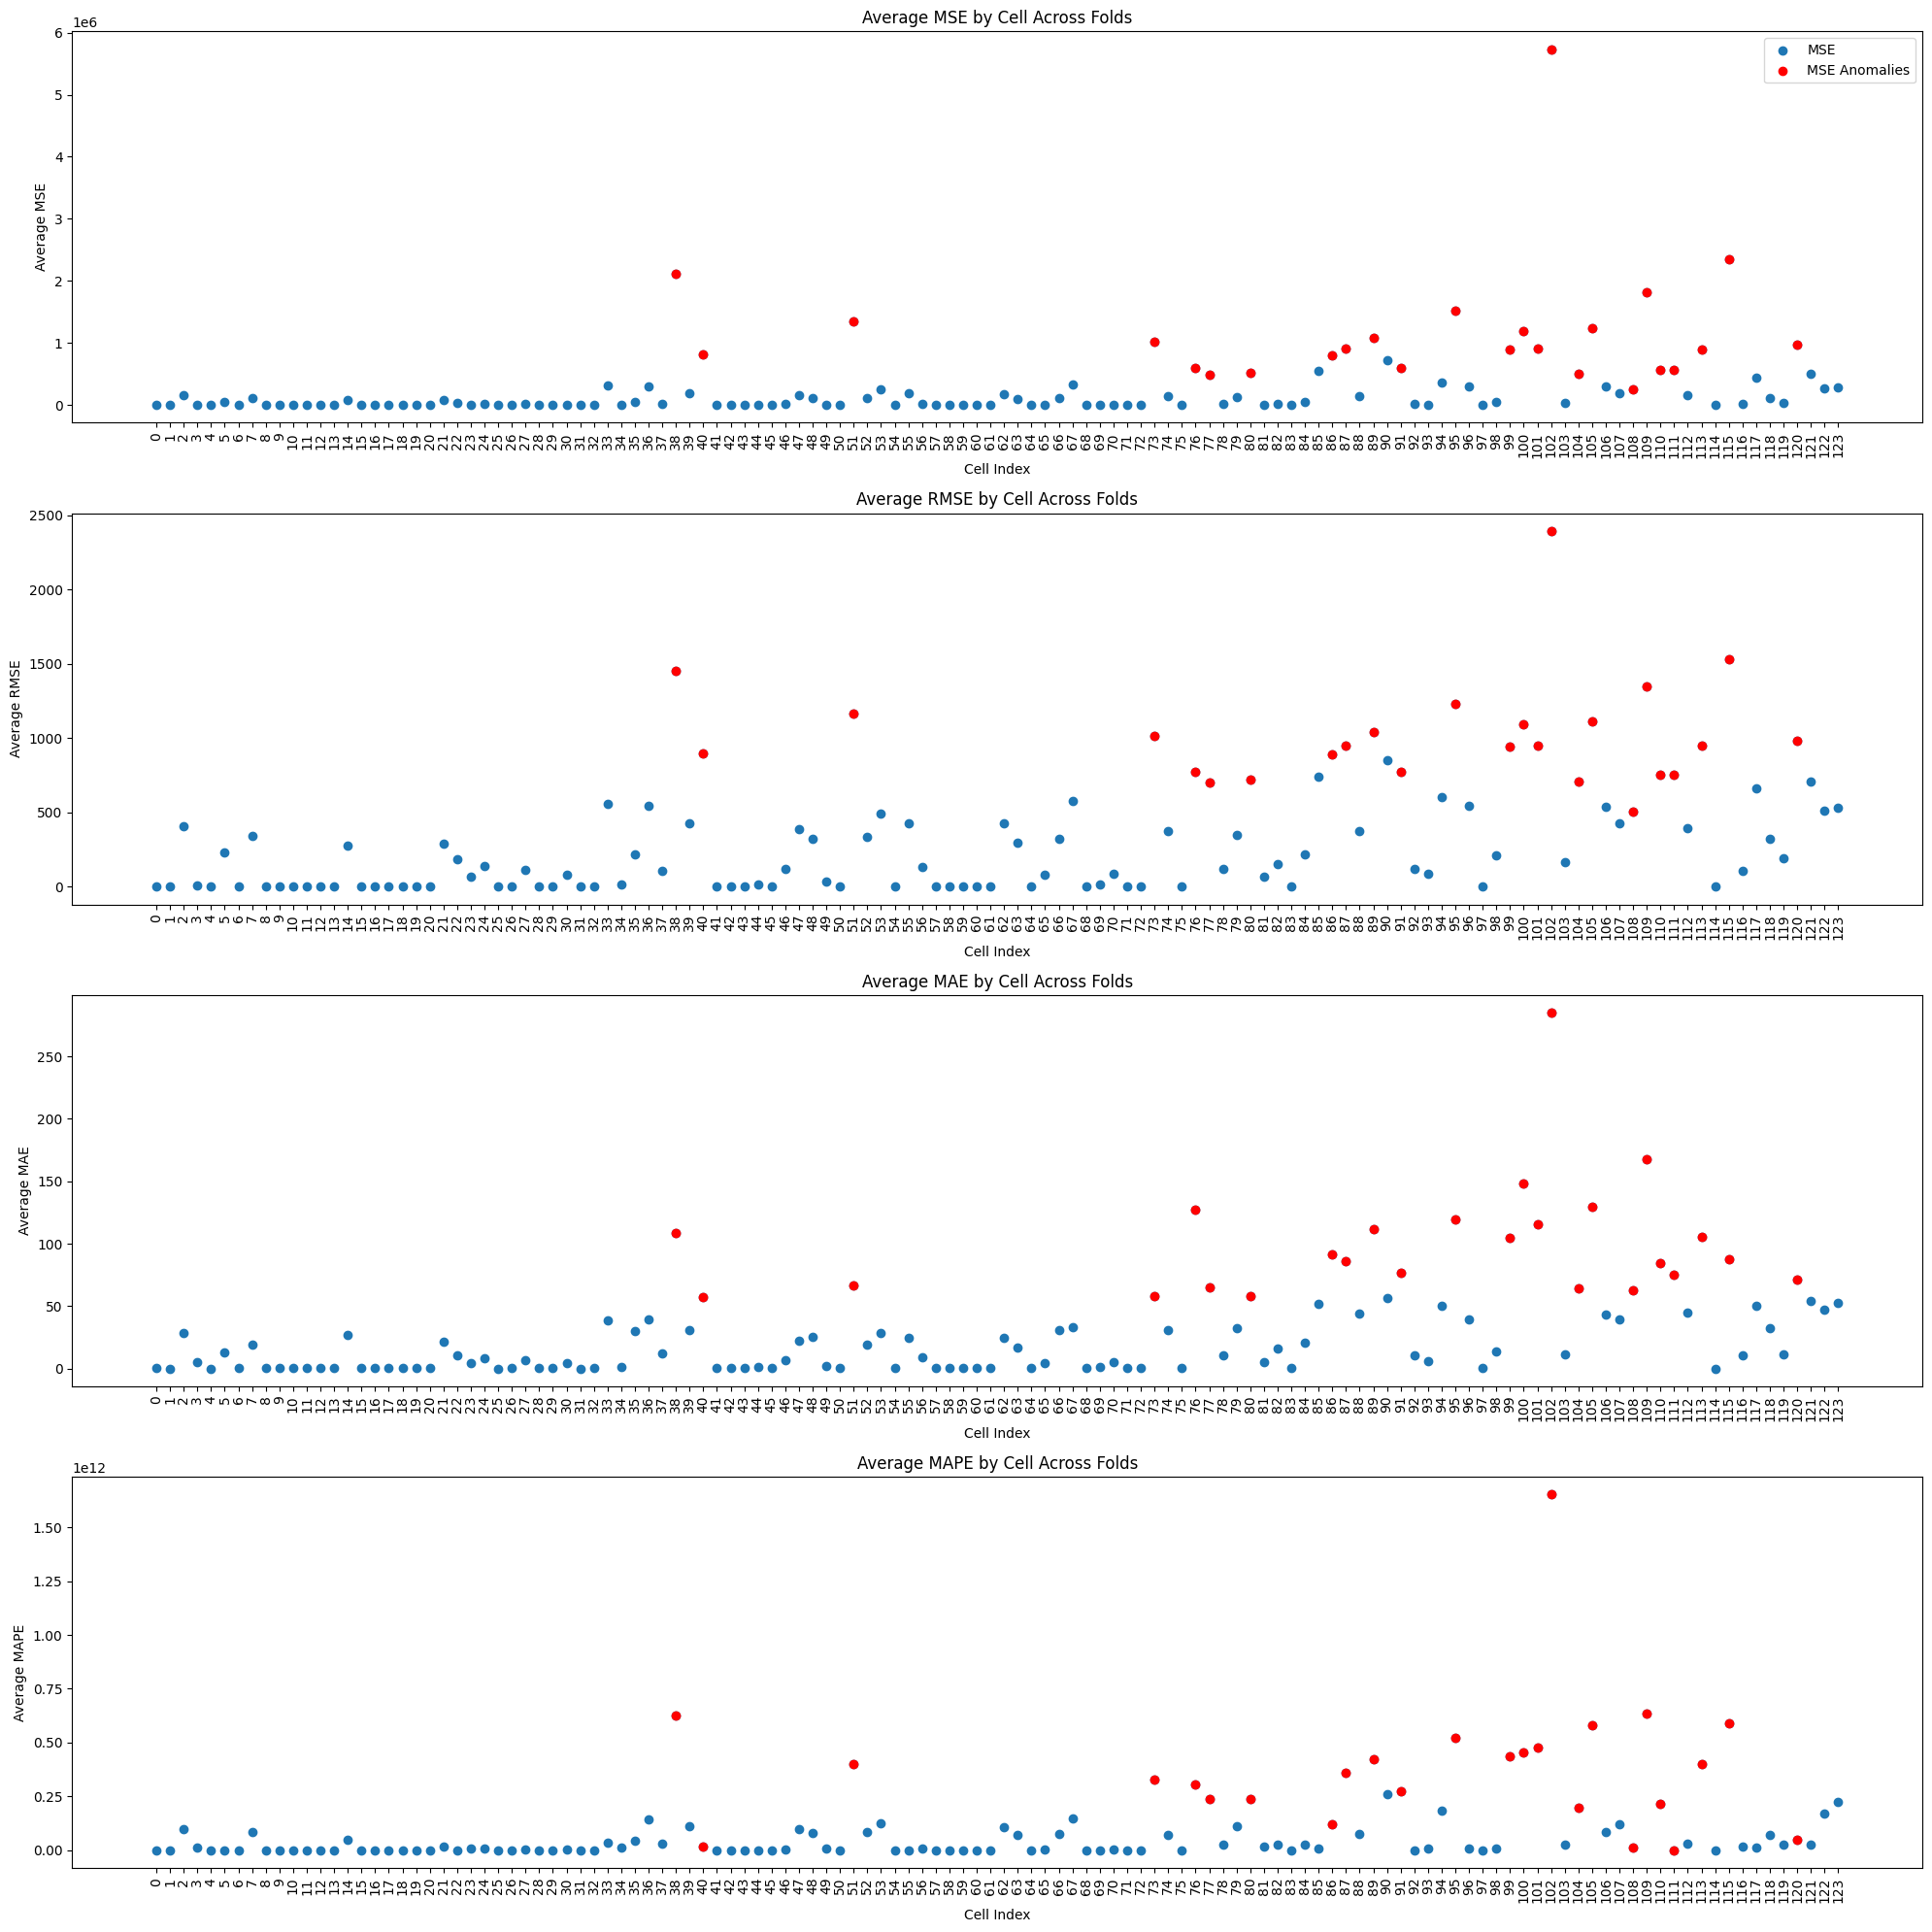

In [66]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()
anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[ 38  51  67  73  76  77  80  87  89  90  91  94  95  99 100 101 102 104
 105 109 110 113 115 122 123]


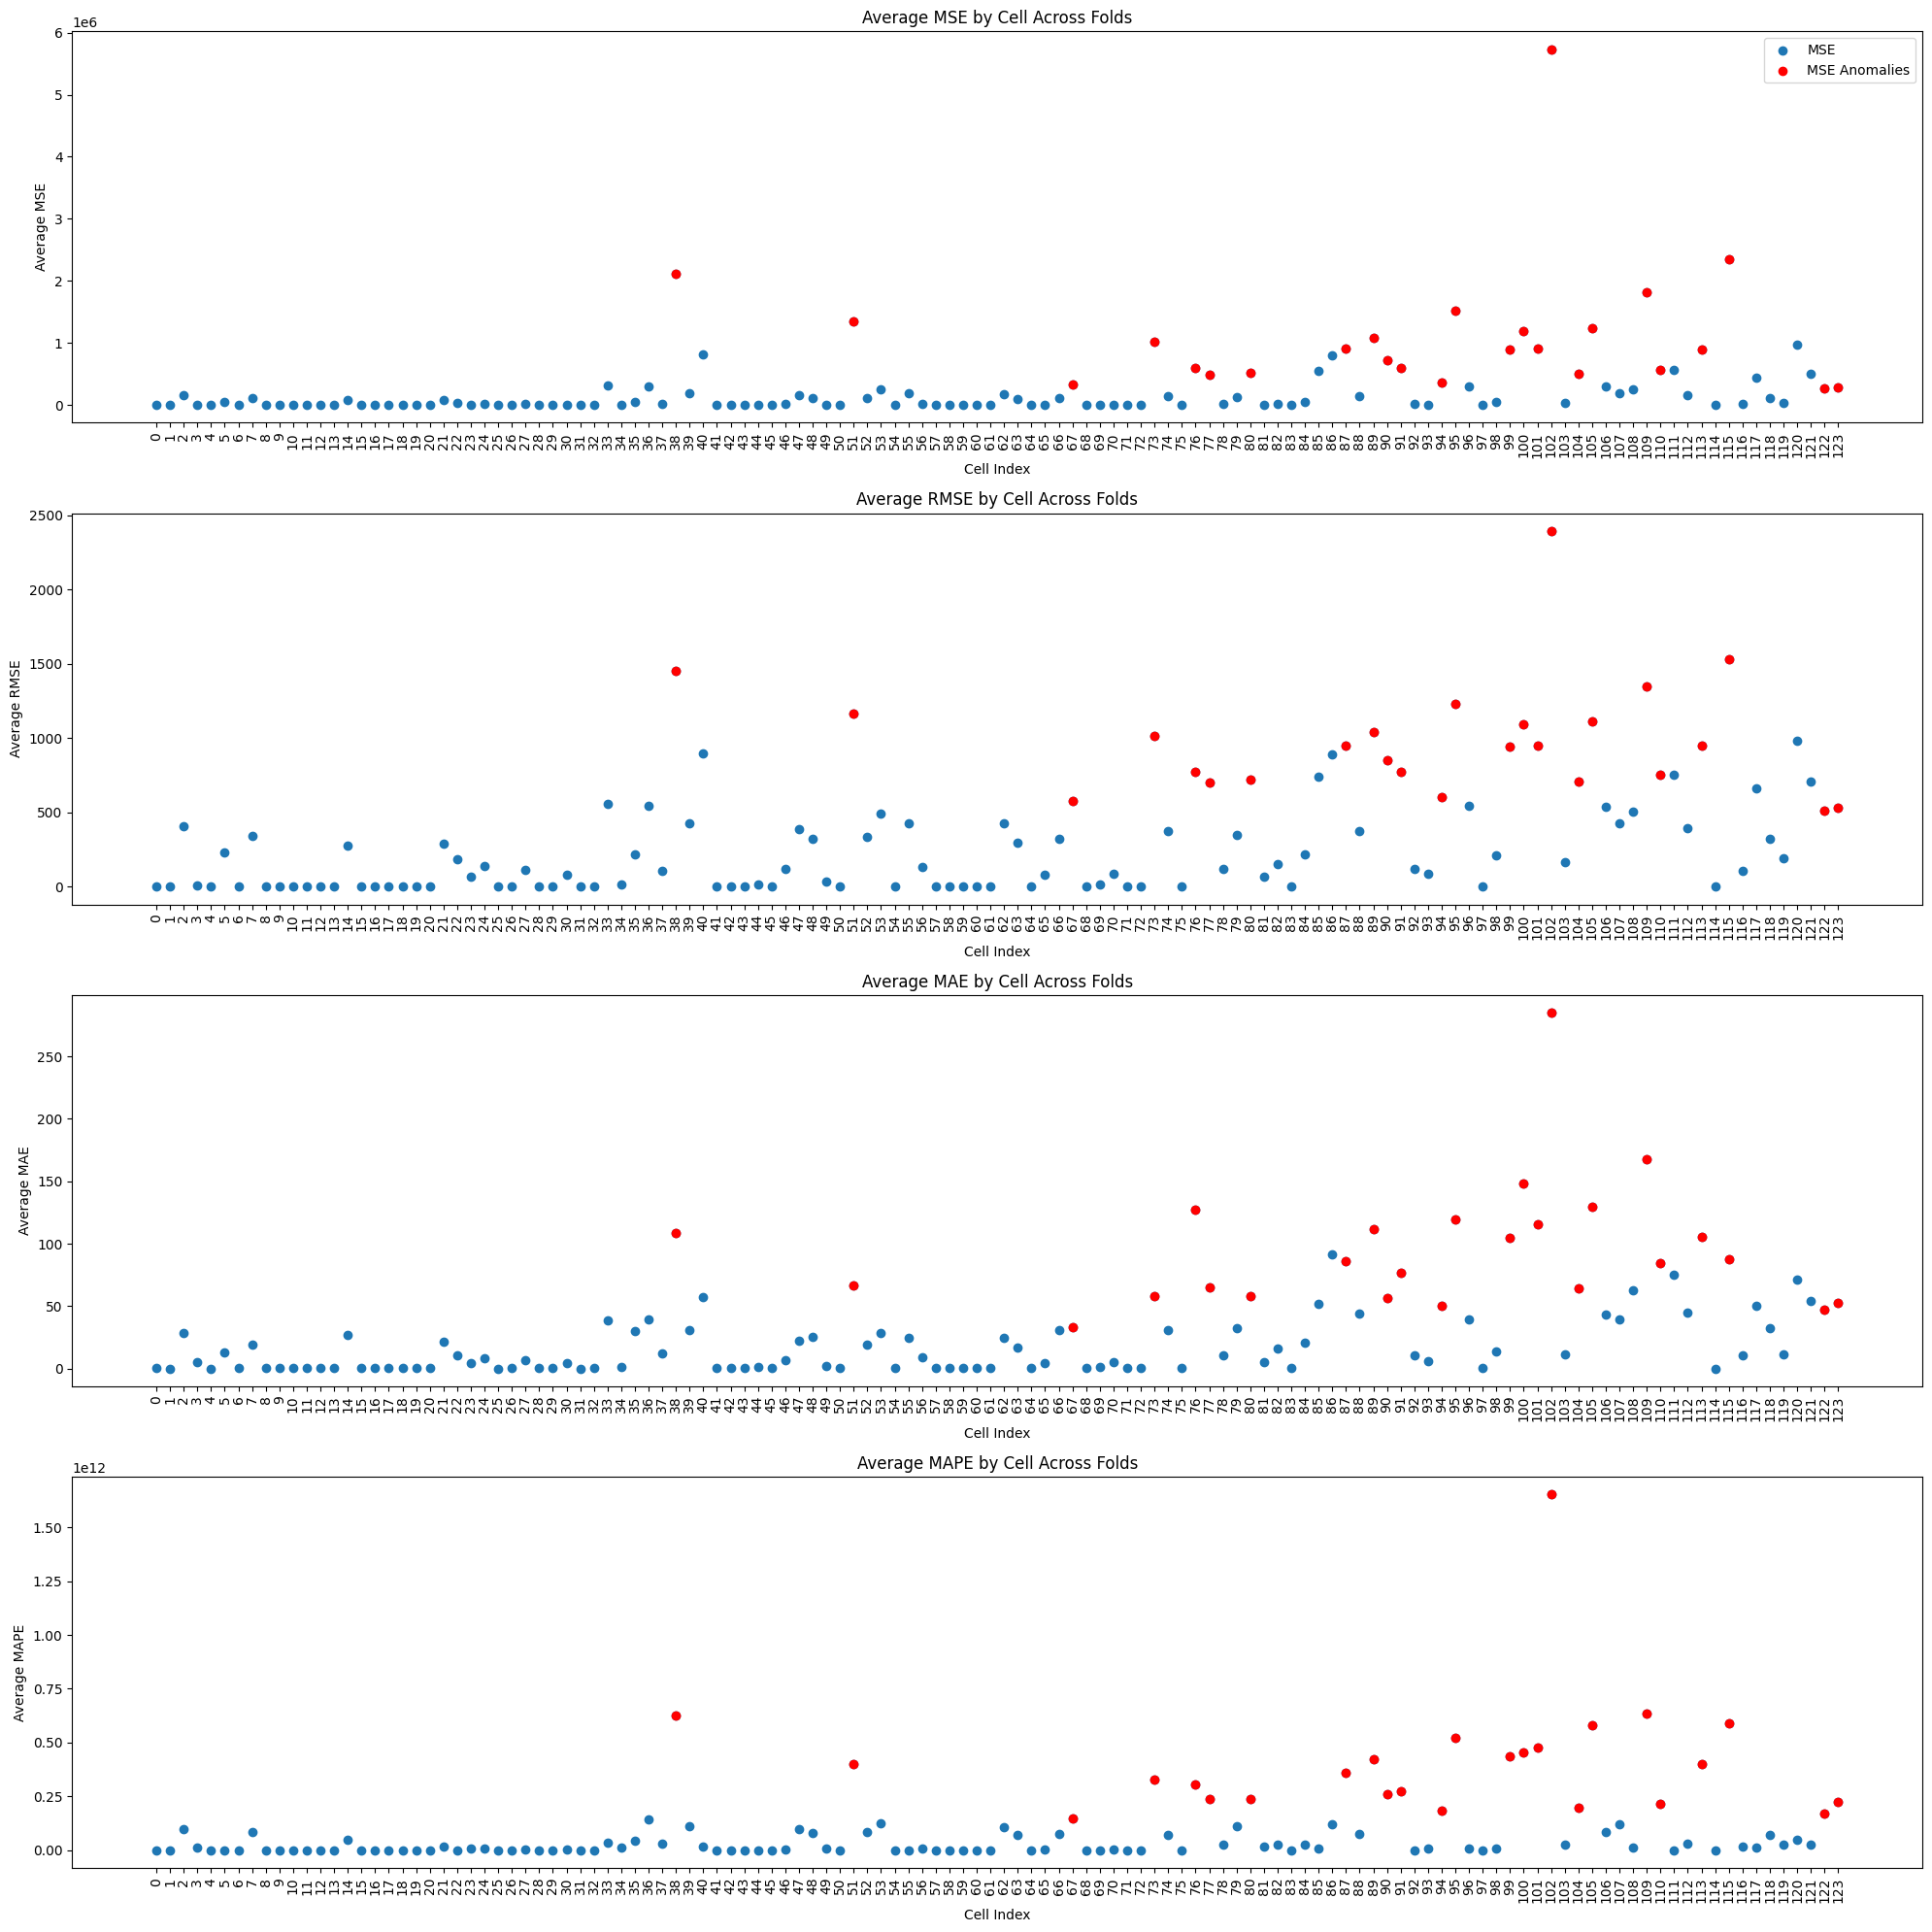

In [67]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

In [ ]:
import tensorflow as tf
import gc
del cae_sd
del cae_sd_model, cae_sd_encoder
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

In [18]:
cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model_t4', batdata, cae_sd_model)

In [19]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=8, max_epoch=300, no_patience=20)

  0%|          | 0/300 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1740570587.909923 1455783 service.cc:145] XLA service 0x55ac27a12b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740570587.910038 1455783 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1740570587.910041 1455783 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-26 20:49:47.968089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-26 20:49:48.345323: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1740570591.134905 1455783 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetim

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[ 32  35  37  38  40  42  44  51  73  76  77  80  82  89  95  99 100 101
 102 105 106 109 113 115 119]


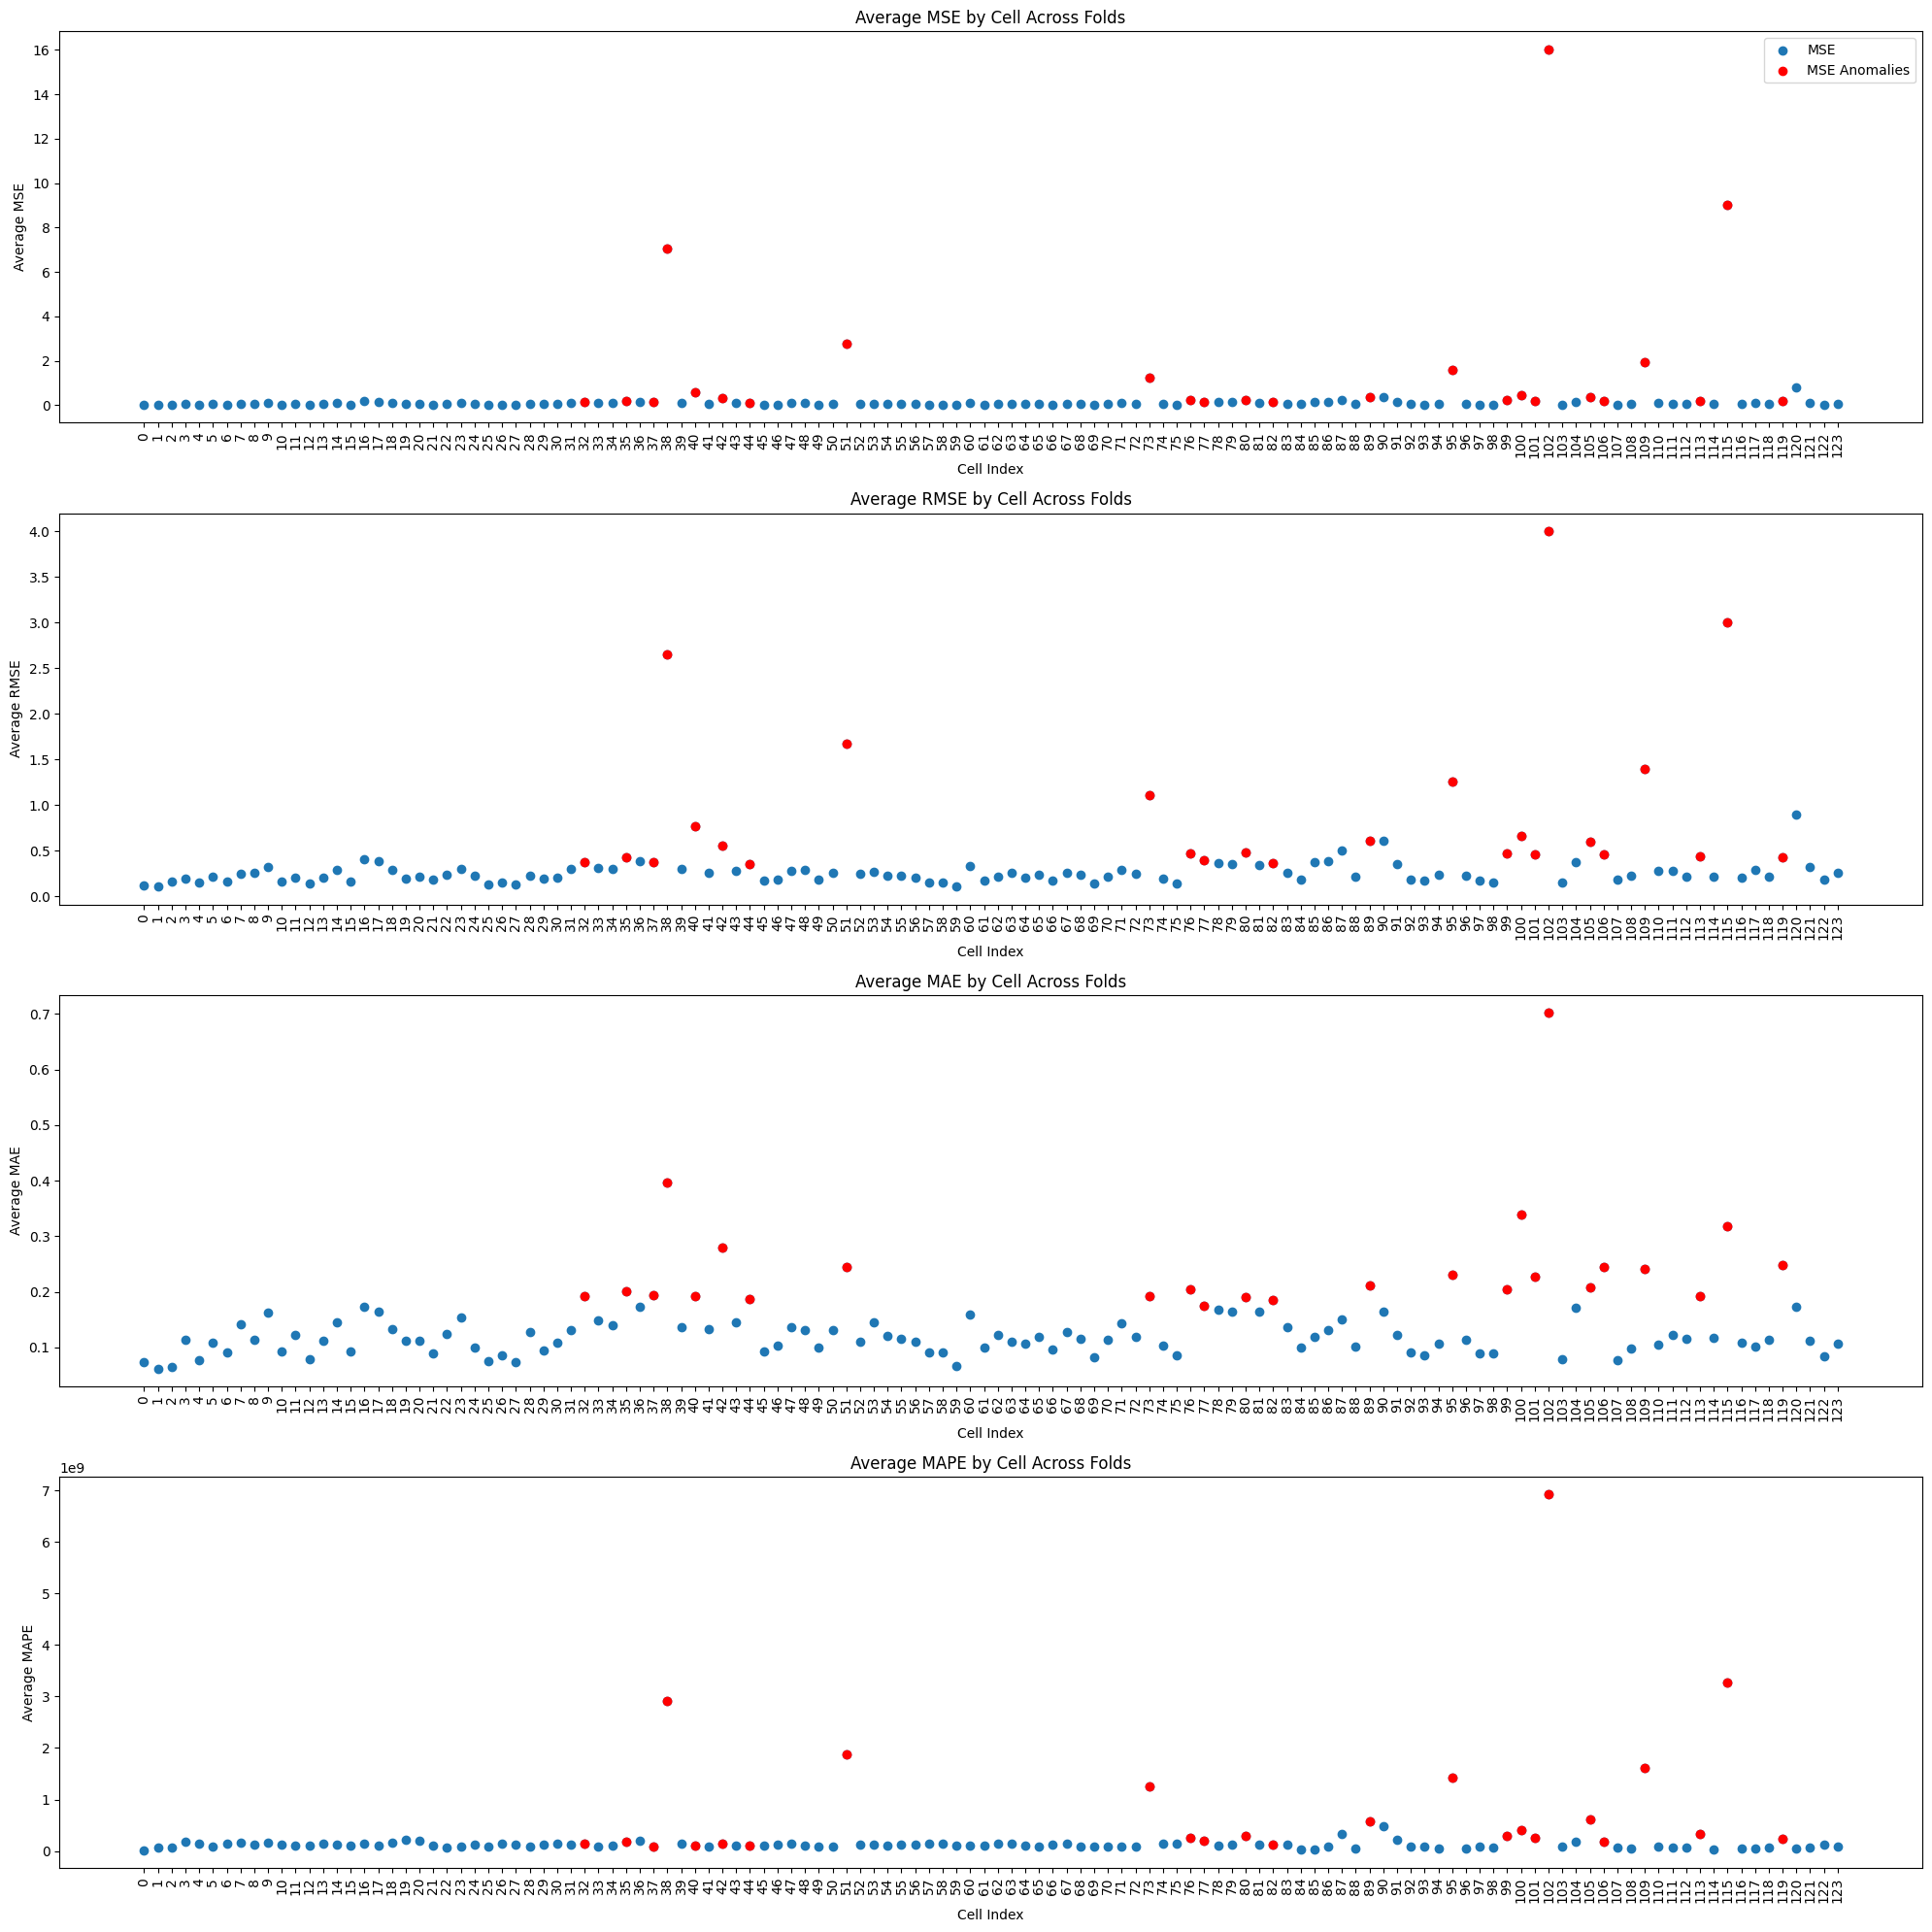

In [20]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()
anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[ 19  20  35  36  38  51  73  76  77  80  87  89  90  91  95  99 100 101
 102 104 105 109 113 115 119]


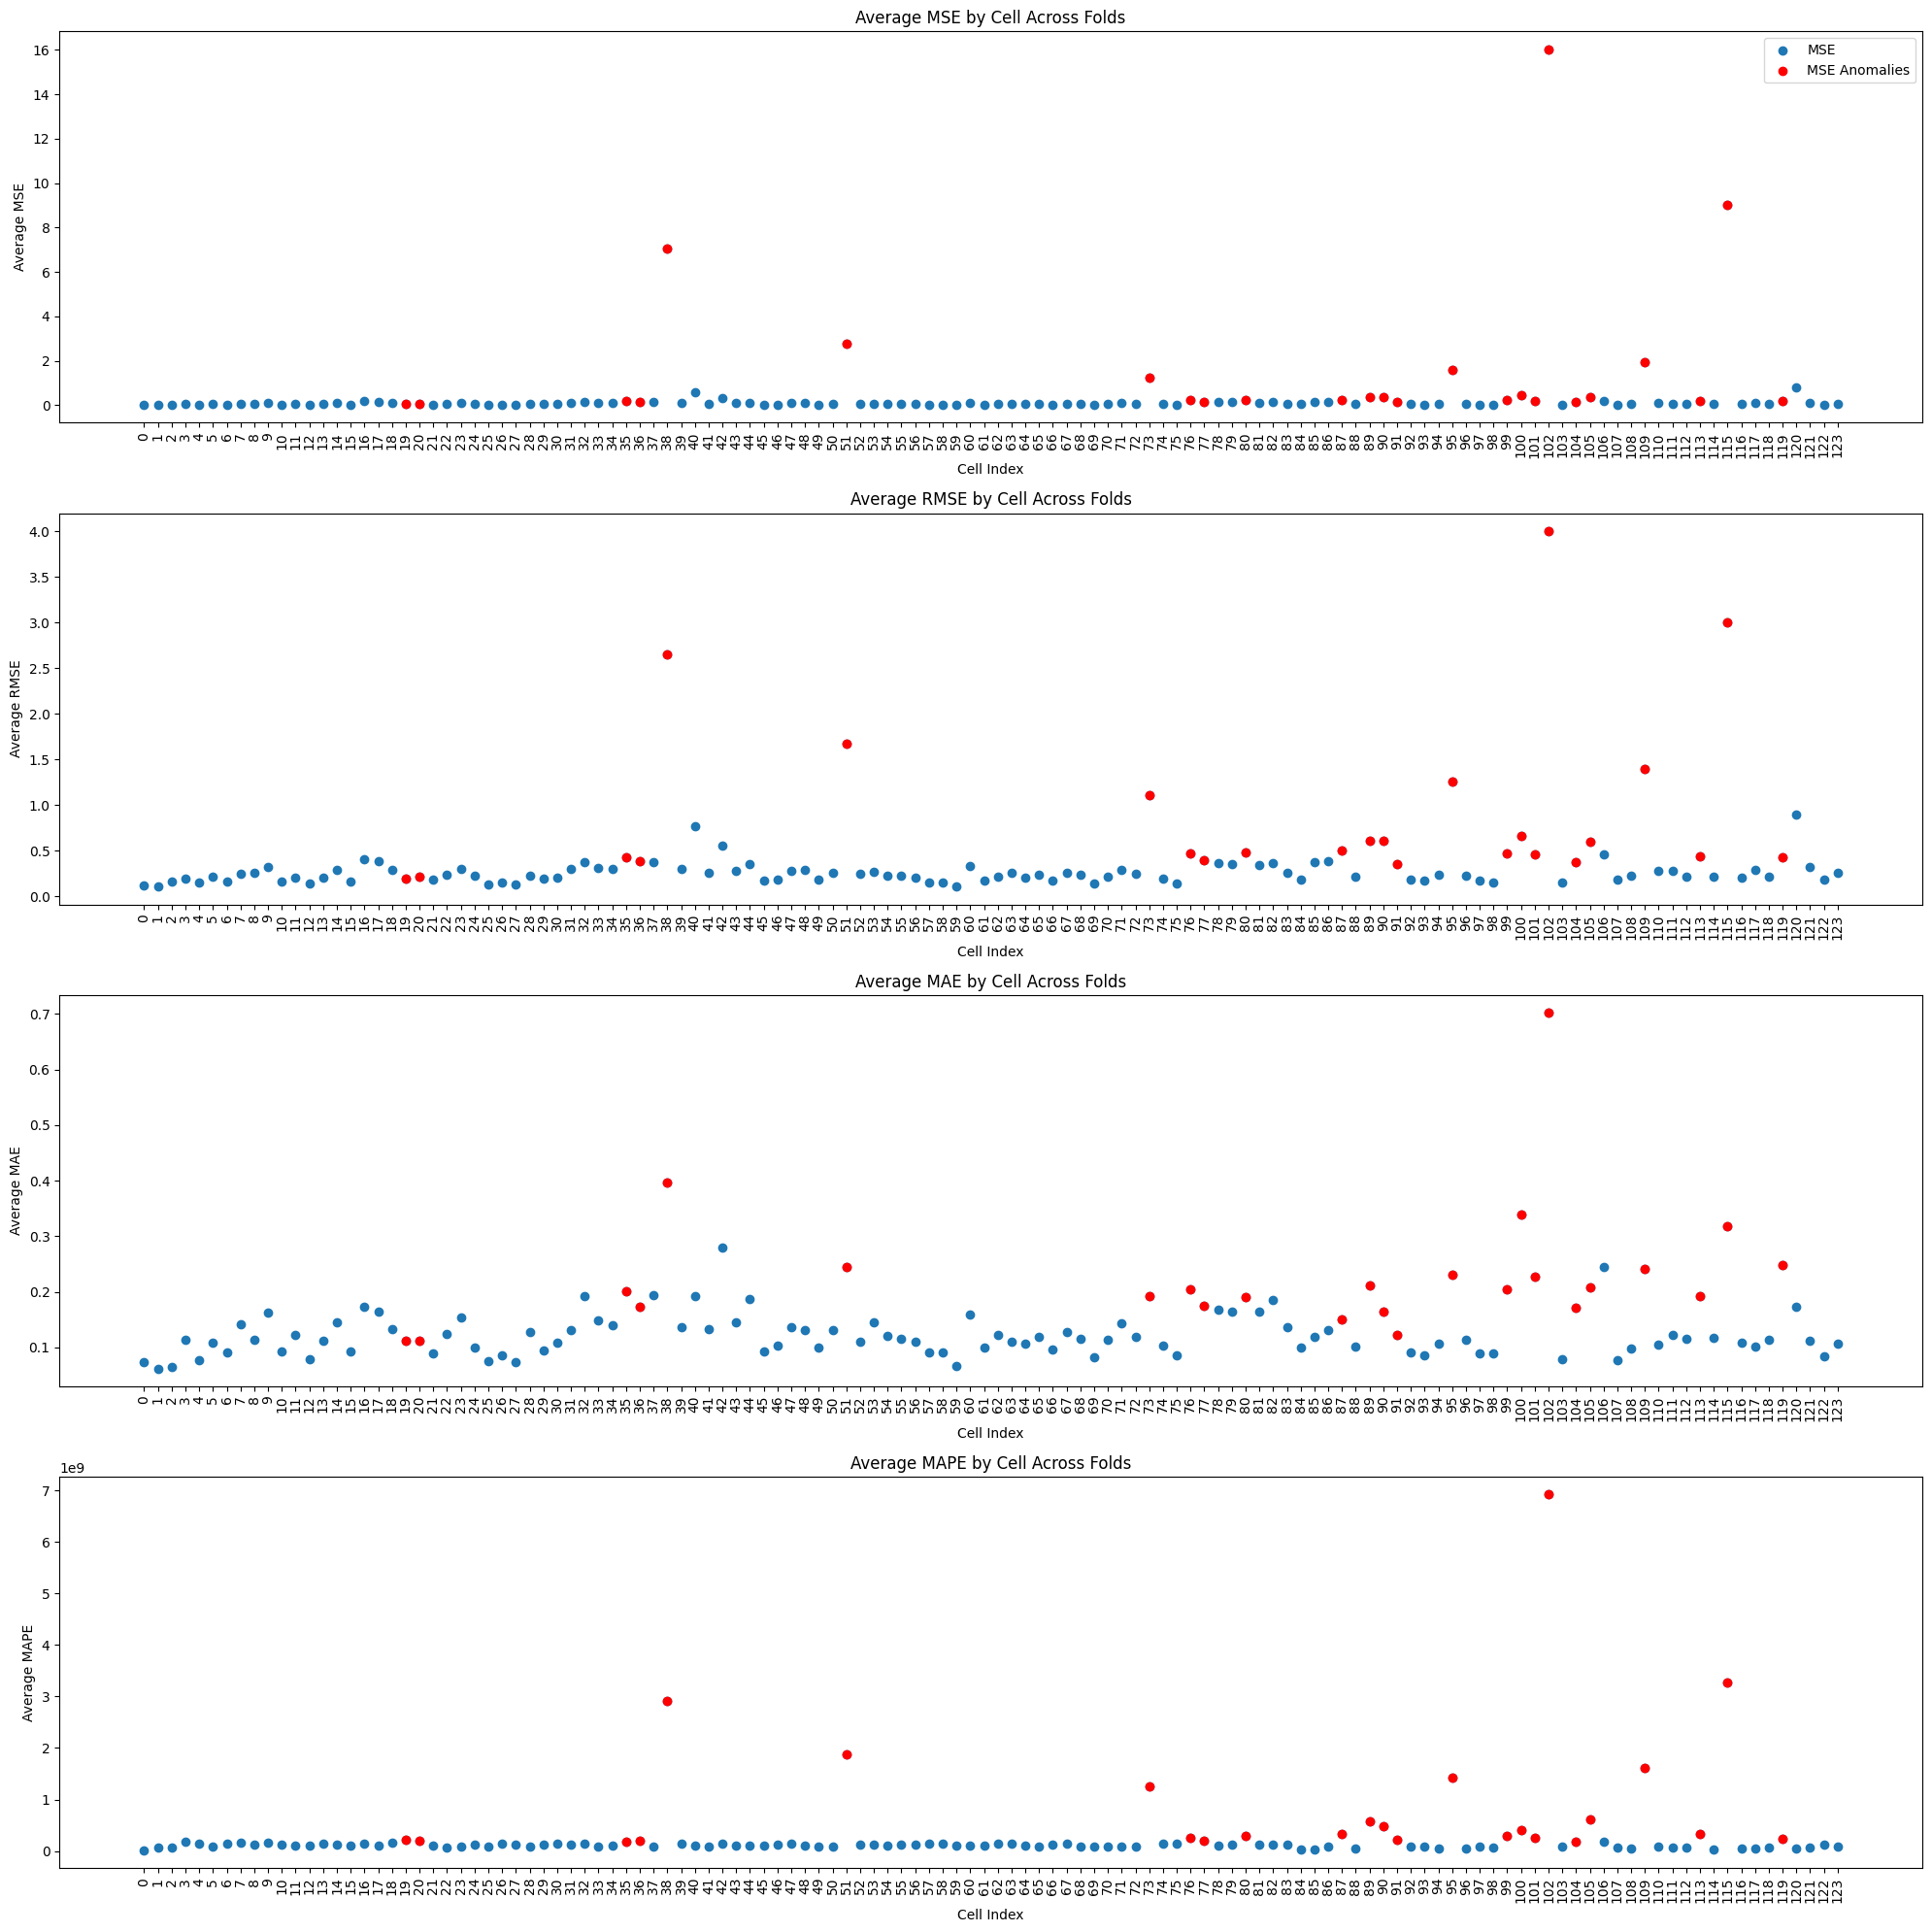

In [21]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

In [22]:
import tensorflow as tf
import gc
del cae_sd
del cae_sd_model, cae_sd_encoder
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

In [23]:
cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model_t5', batdata, cae_sd_model)

In [24]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=16, max_epoch=300, no_patience=20)

0epoch [00:00, ?epoch/s]

 77%|███████▋  | 231/300 [11:26<03:25,  2.97s/epoch, loss=0.000257, mae=0.00801, mape=1.74, rmse=0.0157]


388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[  1   2  38  40  51  73  84  87  89  90  94  95  96 100 101 102 105 106
 109 111 113 114 115 119 120]


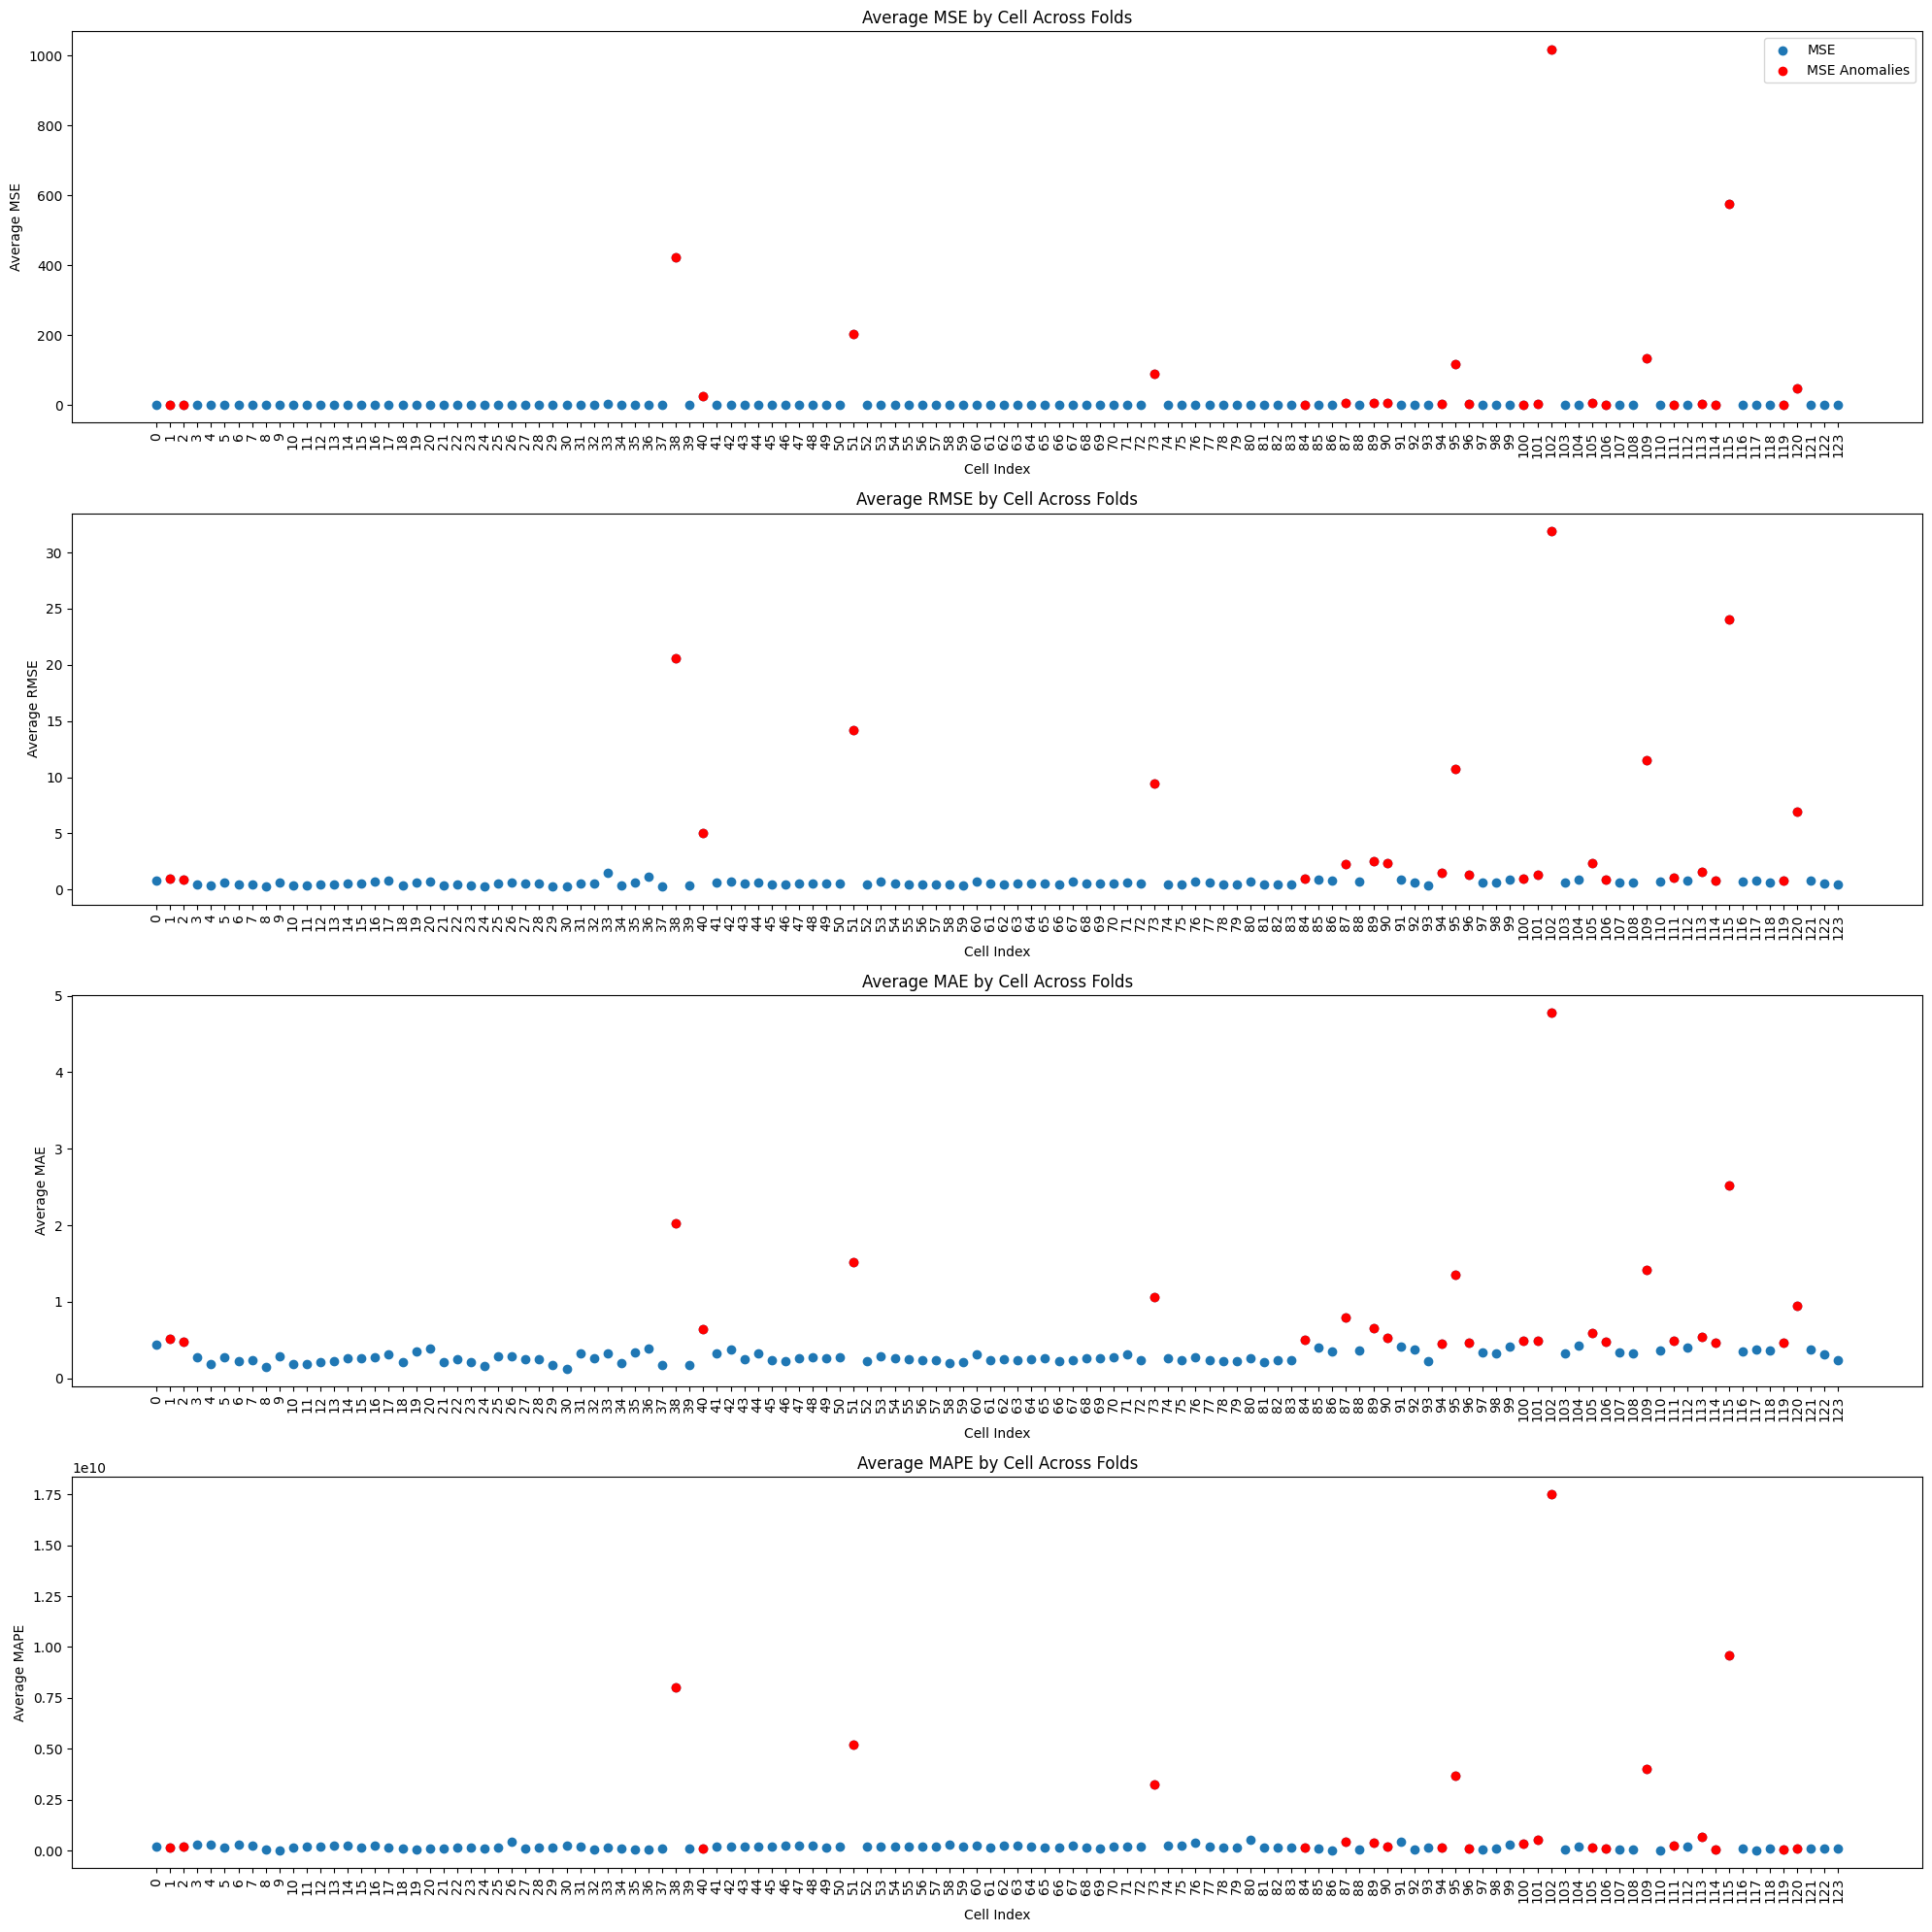

In [25]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()
anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[  3   4   6  16  26  30  38  51  58  60  73  75  76  80  87  89  91  95
  99 100 101 102 109 113 115]


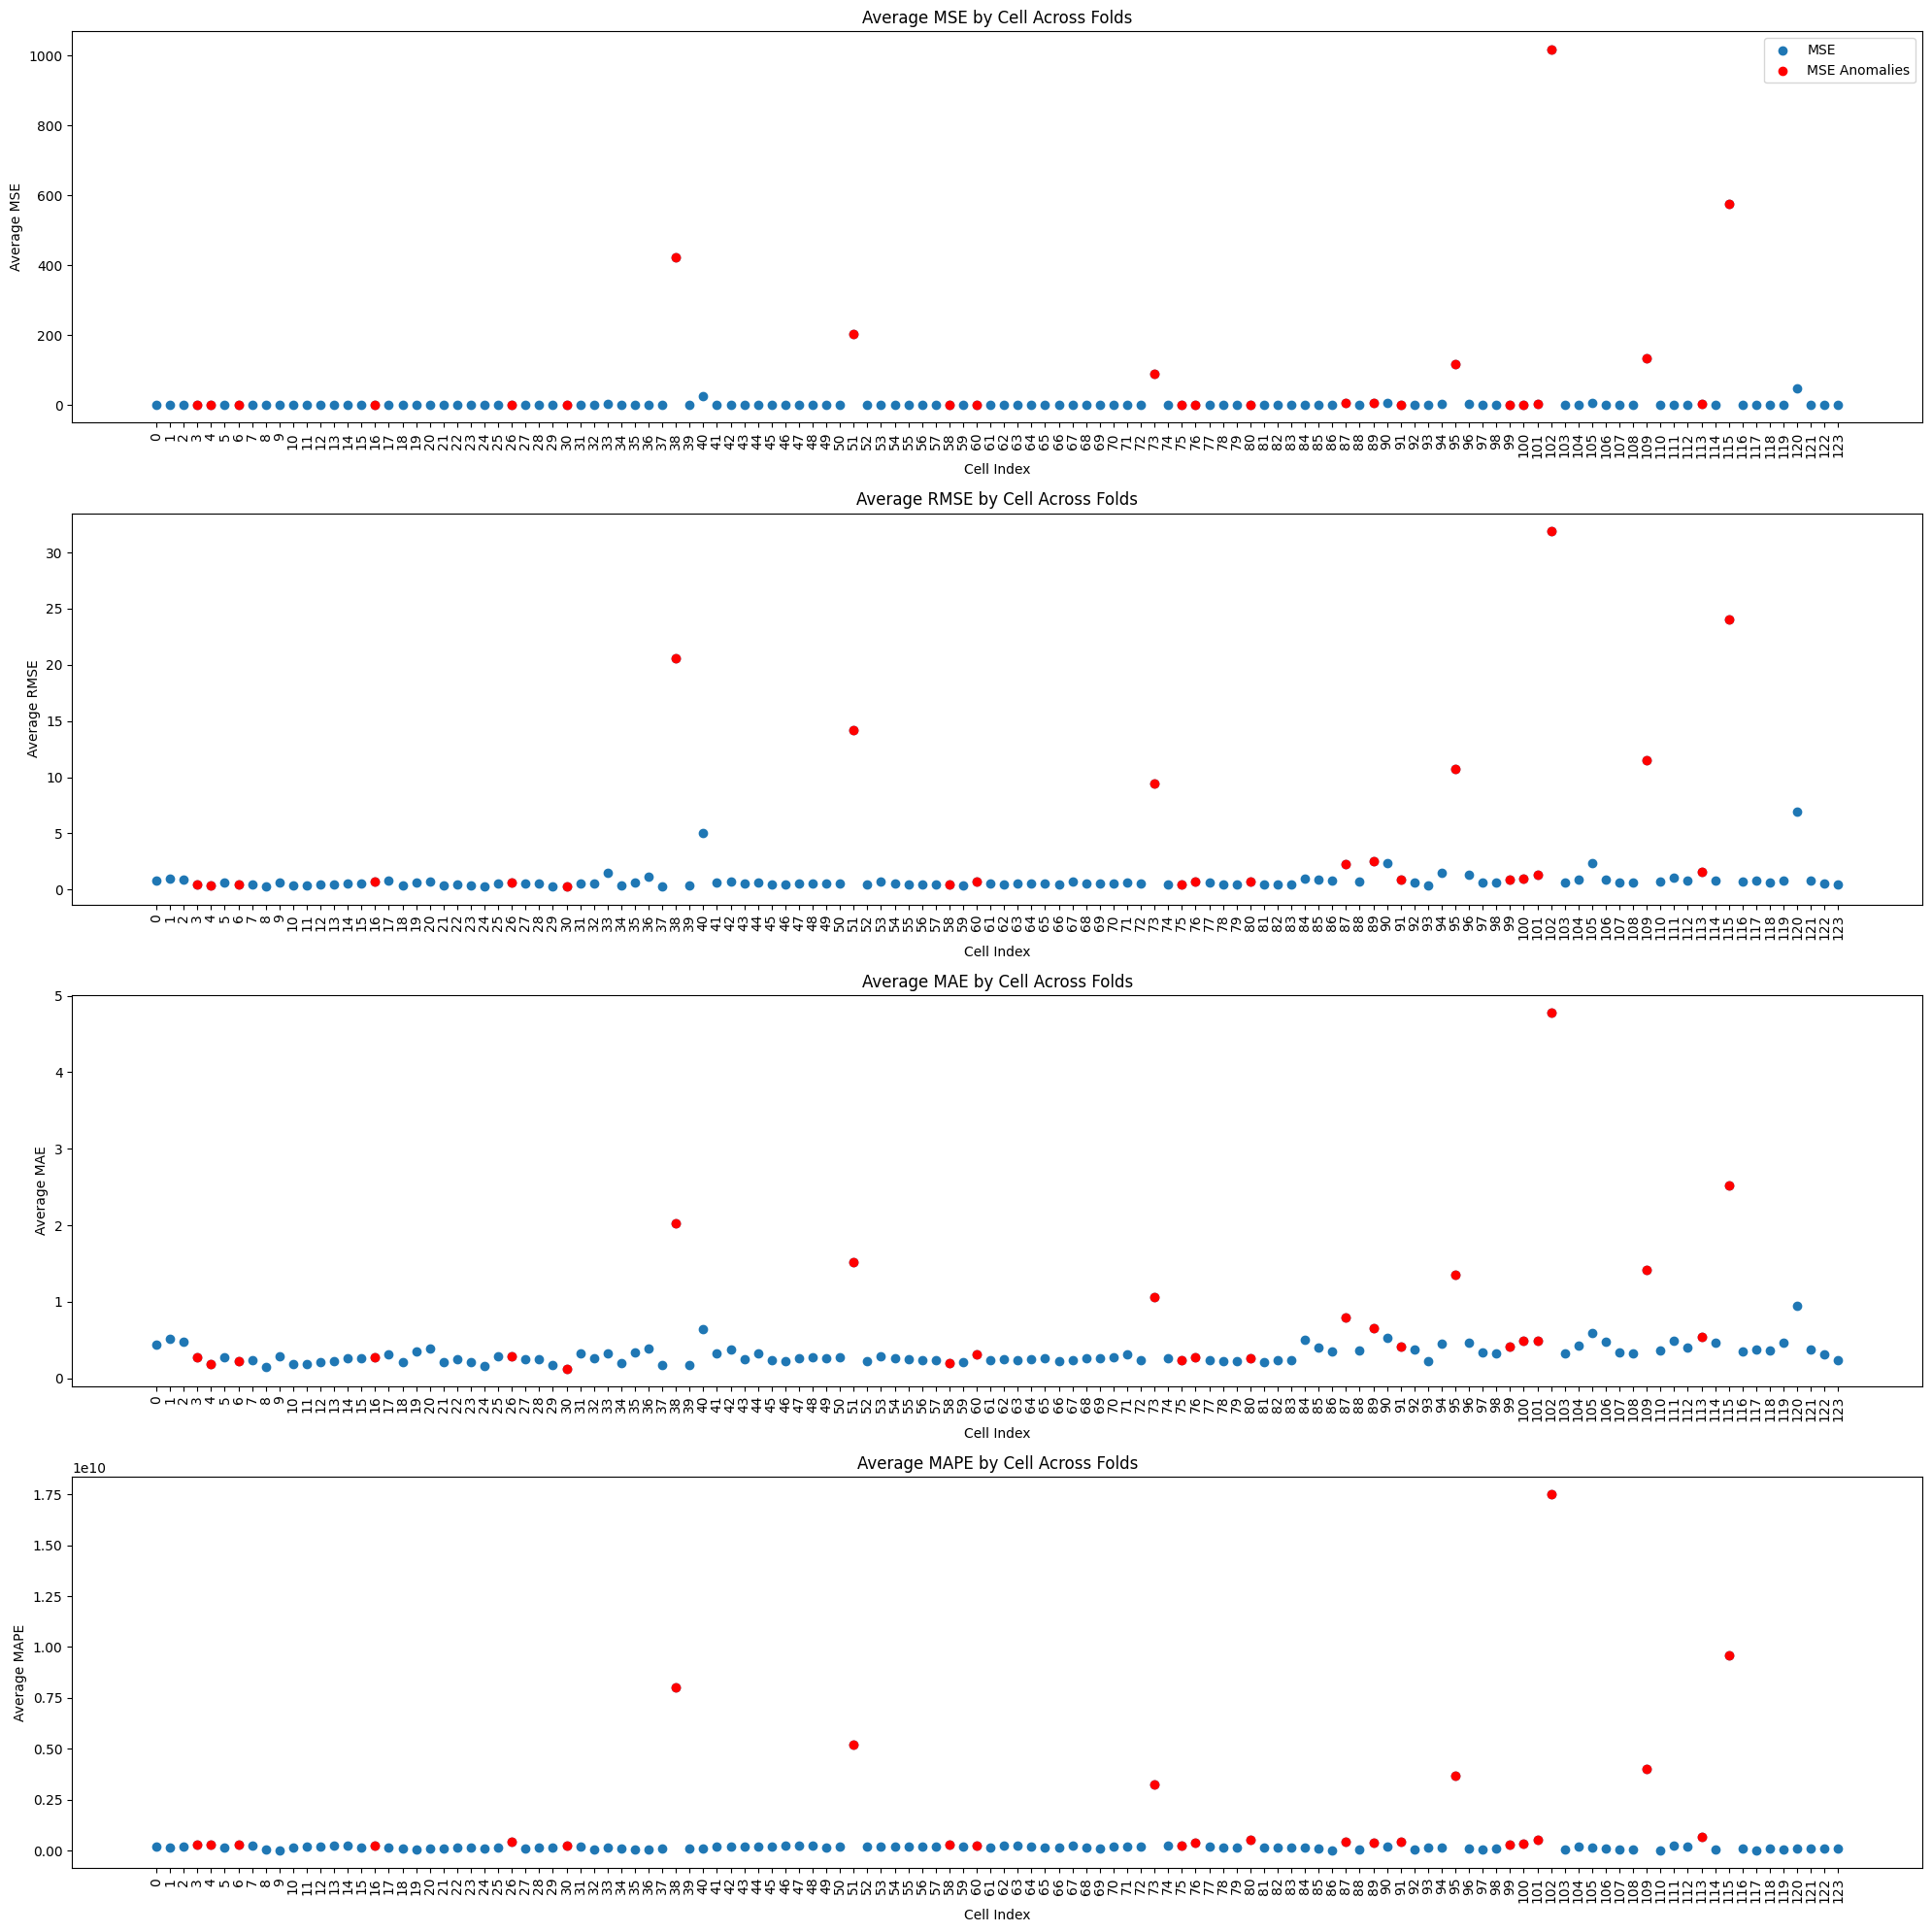

In [26]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

In [27]:
import tensorflow as tf
import gc
del cae_sd
del cae_sd_model, cae_sd_encoder
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()
cae_sd_model, cae_sd_encoder = create_cae_sd(reshaped_cycle_sum.shape[2],
                                             fixed_channel_dim=1,
                                             use_bn=True,
                                             kernel_size=3,
                                             no_of_filters=128)

In [28]:
cae_sd = AutoencoderTrainer(base_dir, 'cae_sd_model_t6', batdata, cae_sd_model)

In [29]:
# this is just for testing of patience
cae_sd.train(learning_rate = 0.001, batch_size=32, max_epoch=300, no_patience=20)

 39%|███▉      | 117/300 [03:04<04:48,  1.58s/epoch, loss=0.000432, mae=0.0119, mape=2.42, rmse=0.0205] 


388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[  3   5   8   9  14  16  17  19  23  24  29  31  32  35  36  38  41  42
  44  47  55  60  90  99 111]


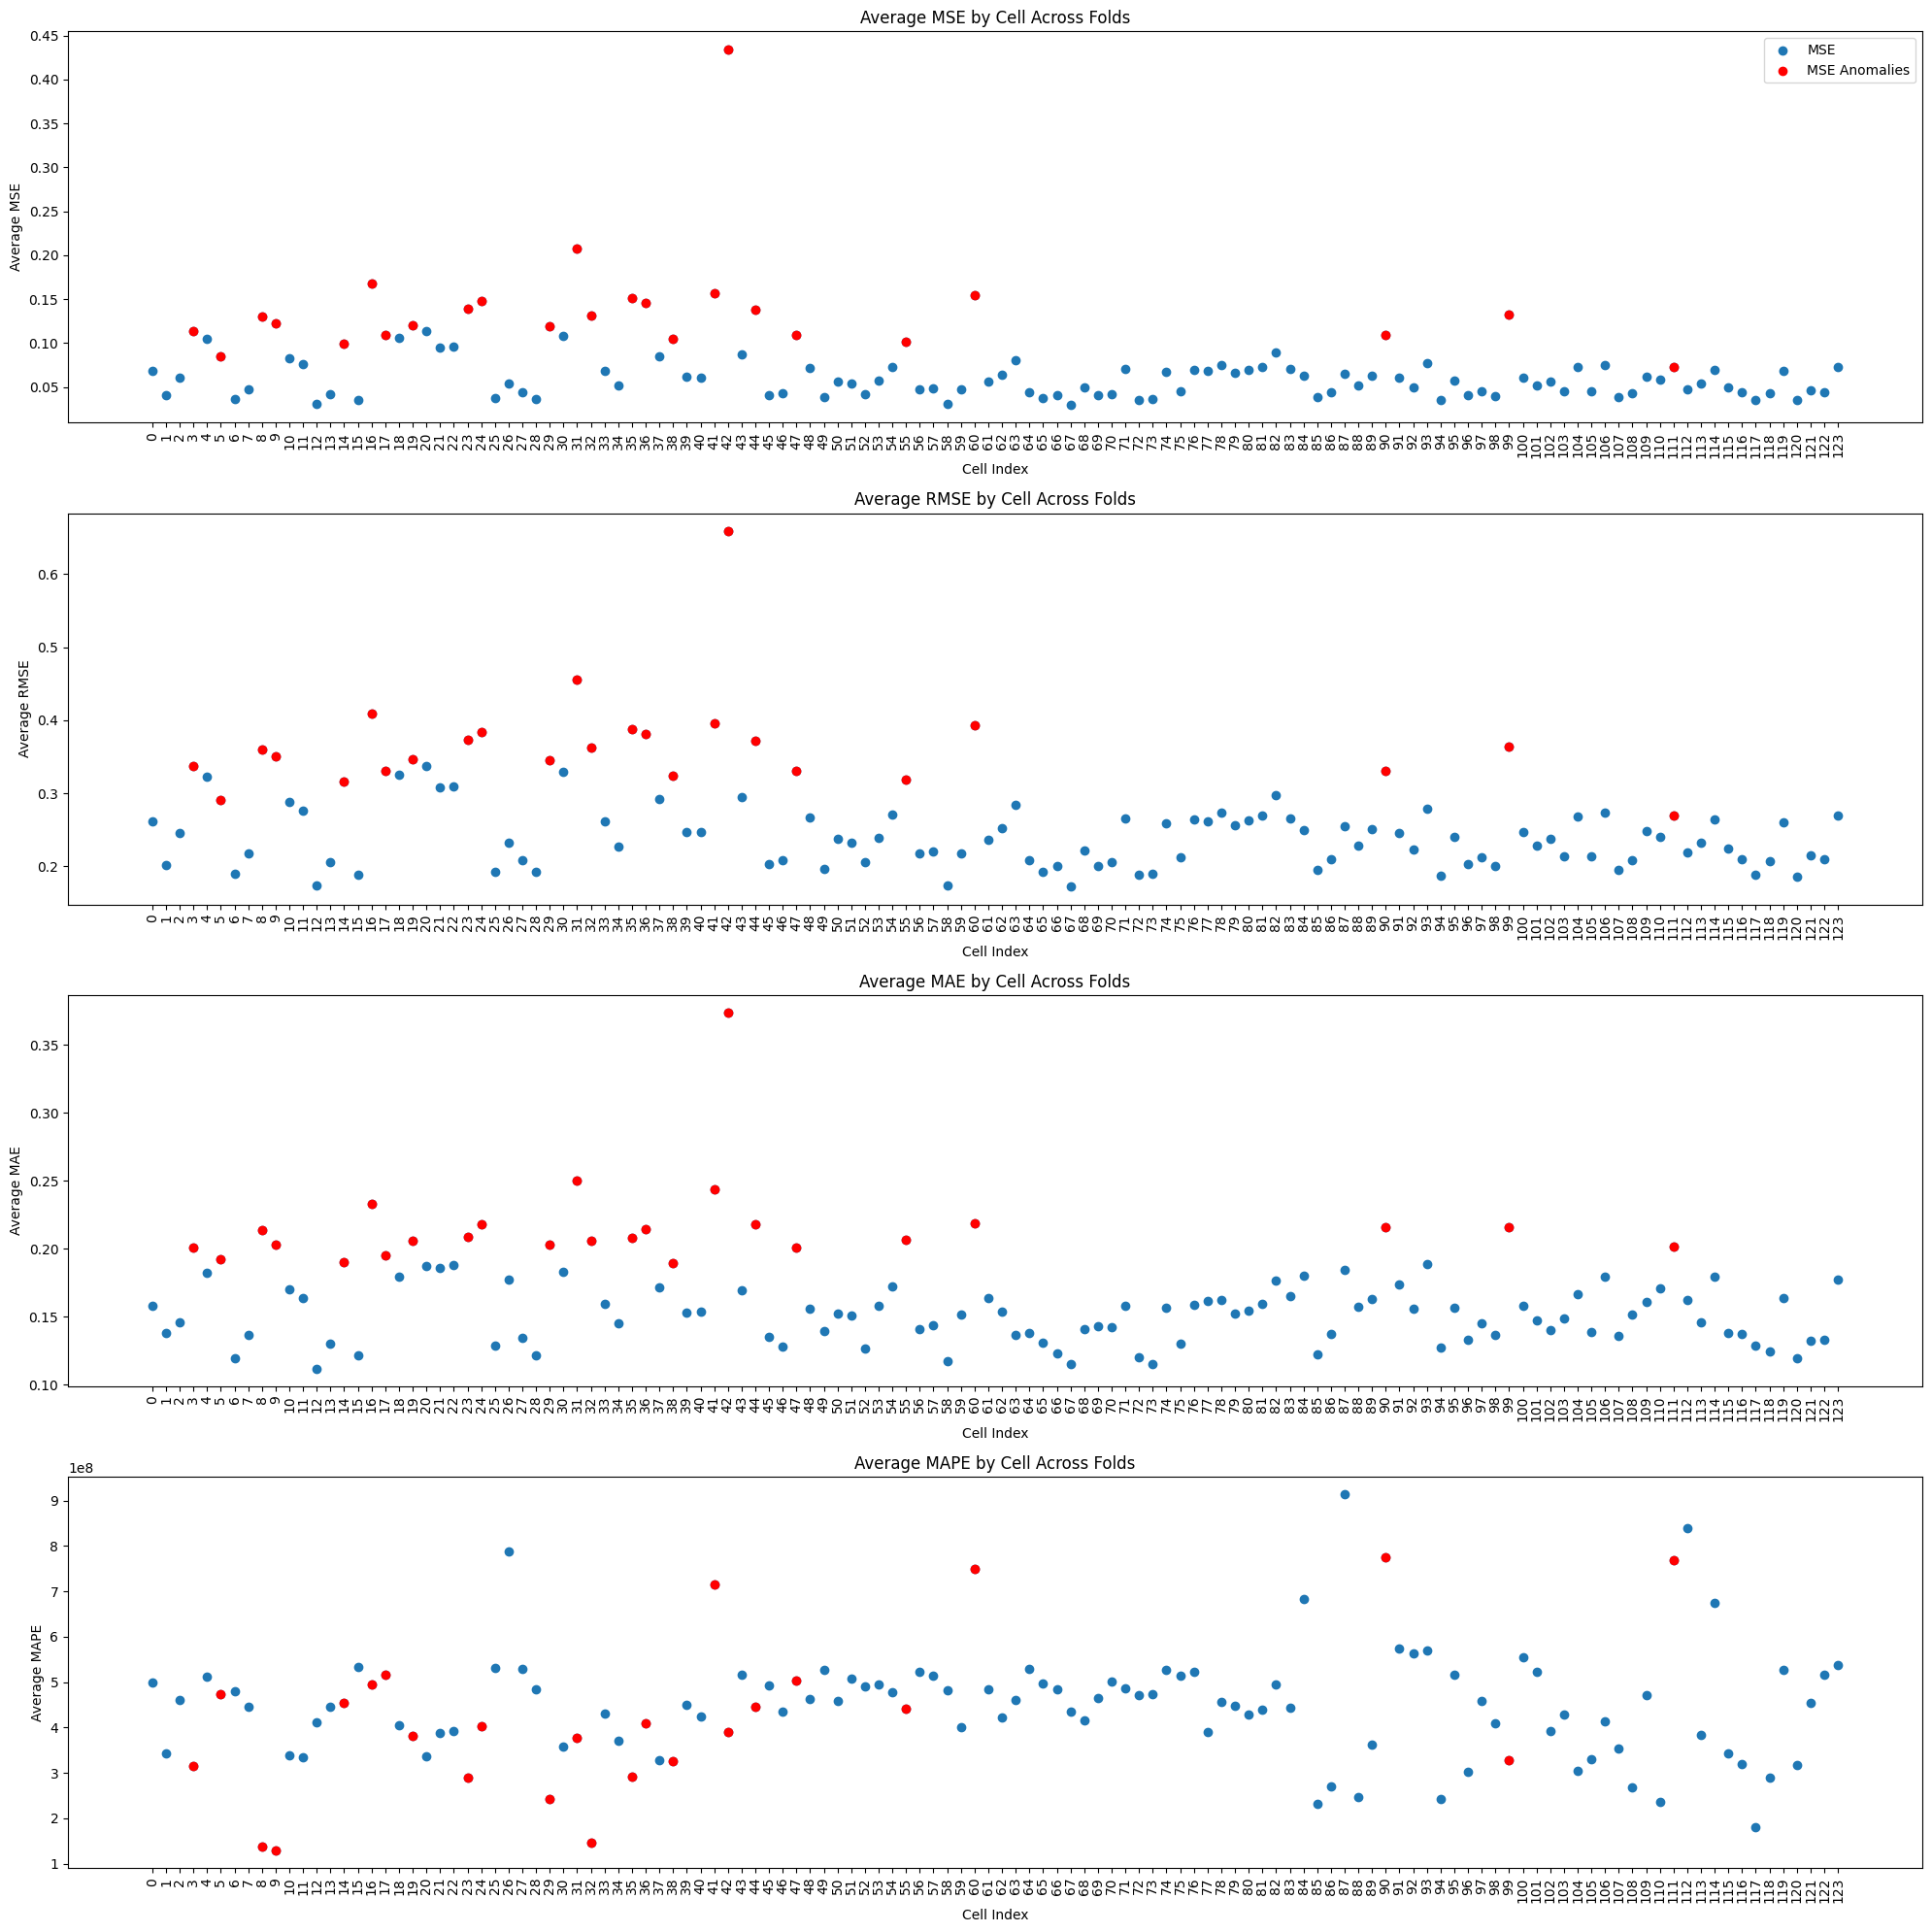

In [30]:
cae_sd_average_error_metrics_by_cells = cae_sd.evaluate()
anomaly_detector_cae_sd= AnomalyDetector()
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mae',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)

[ 15  17  25  26  27  41  49  56  60  64  74  76  84  87  90  91  92  93
 100 101 111 112 114 119 123]


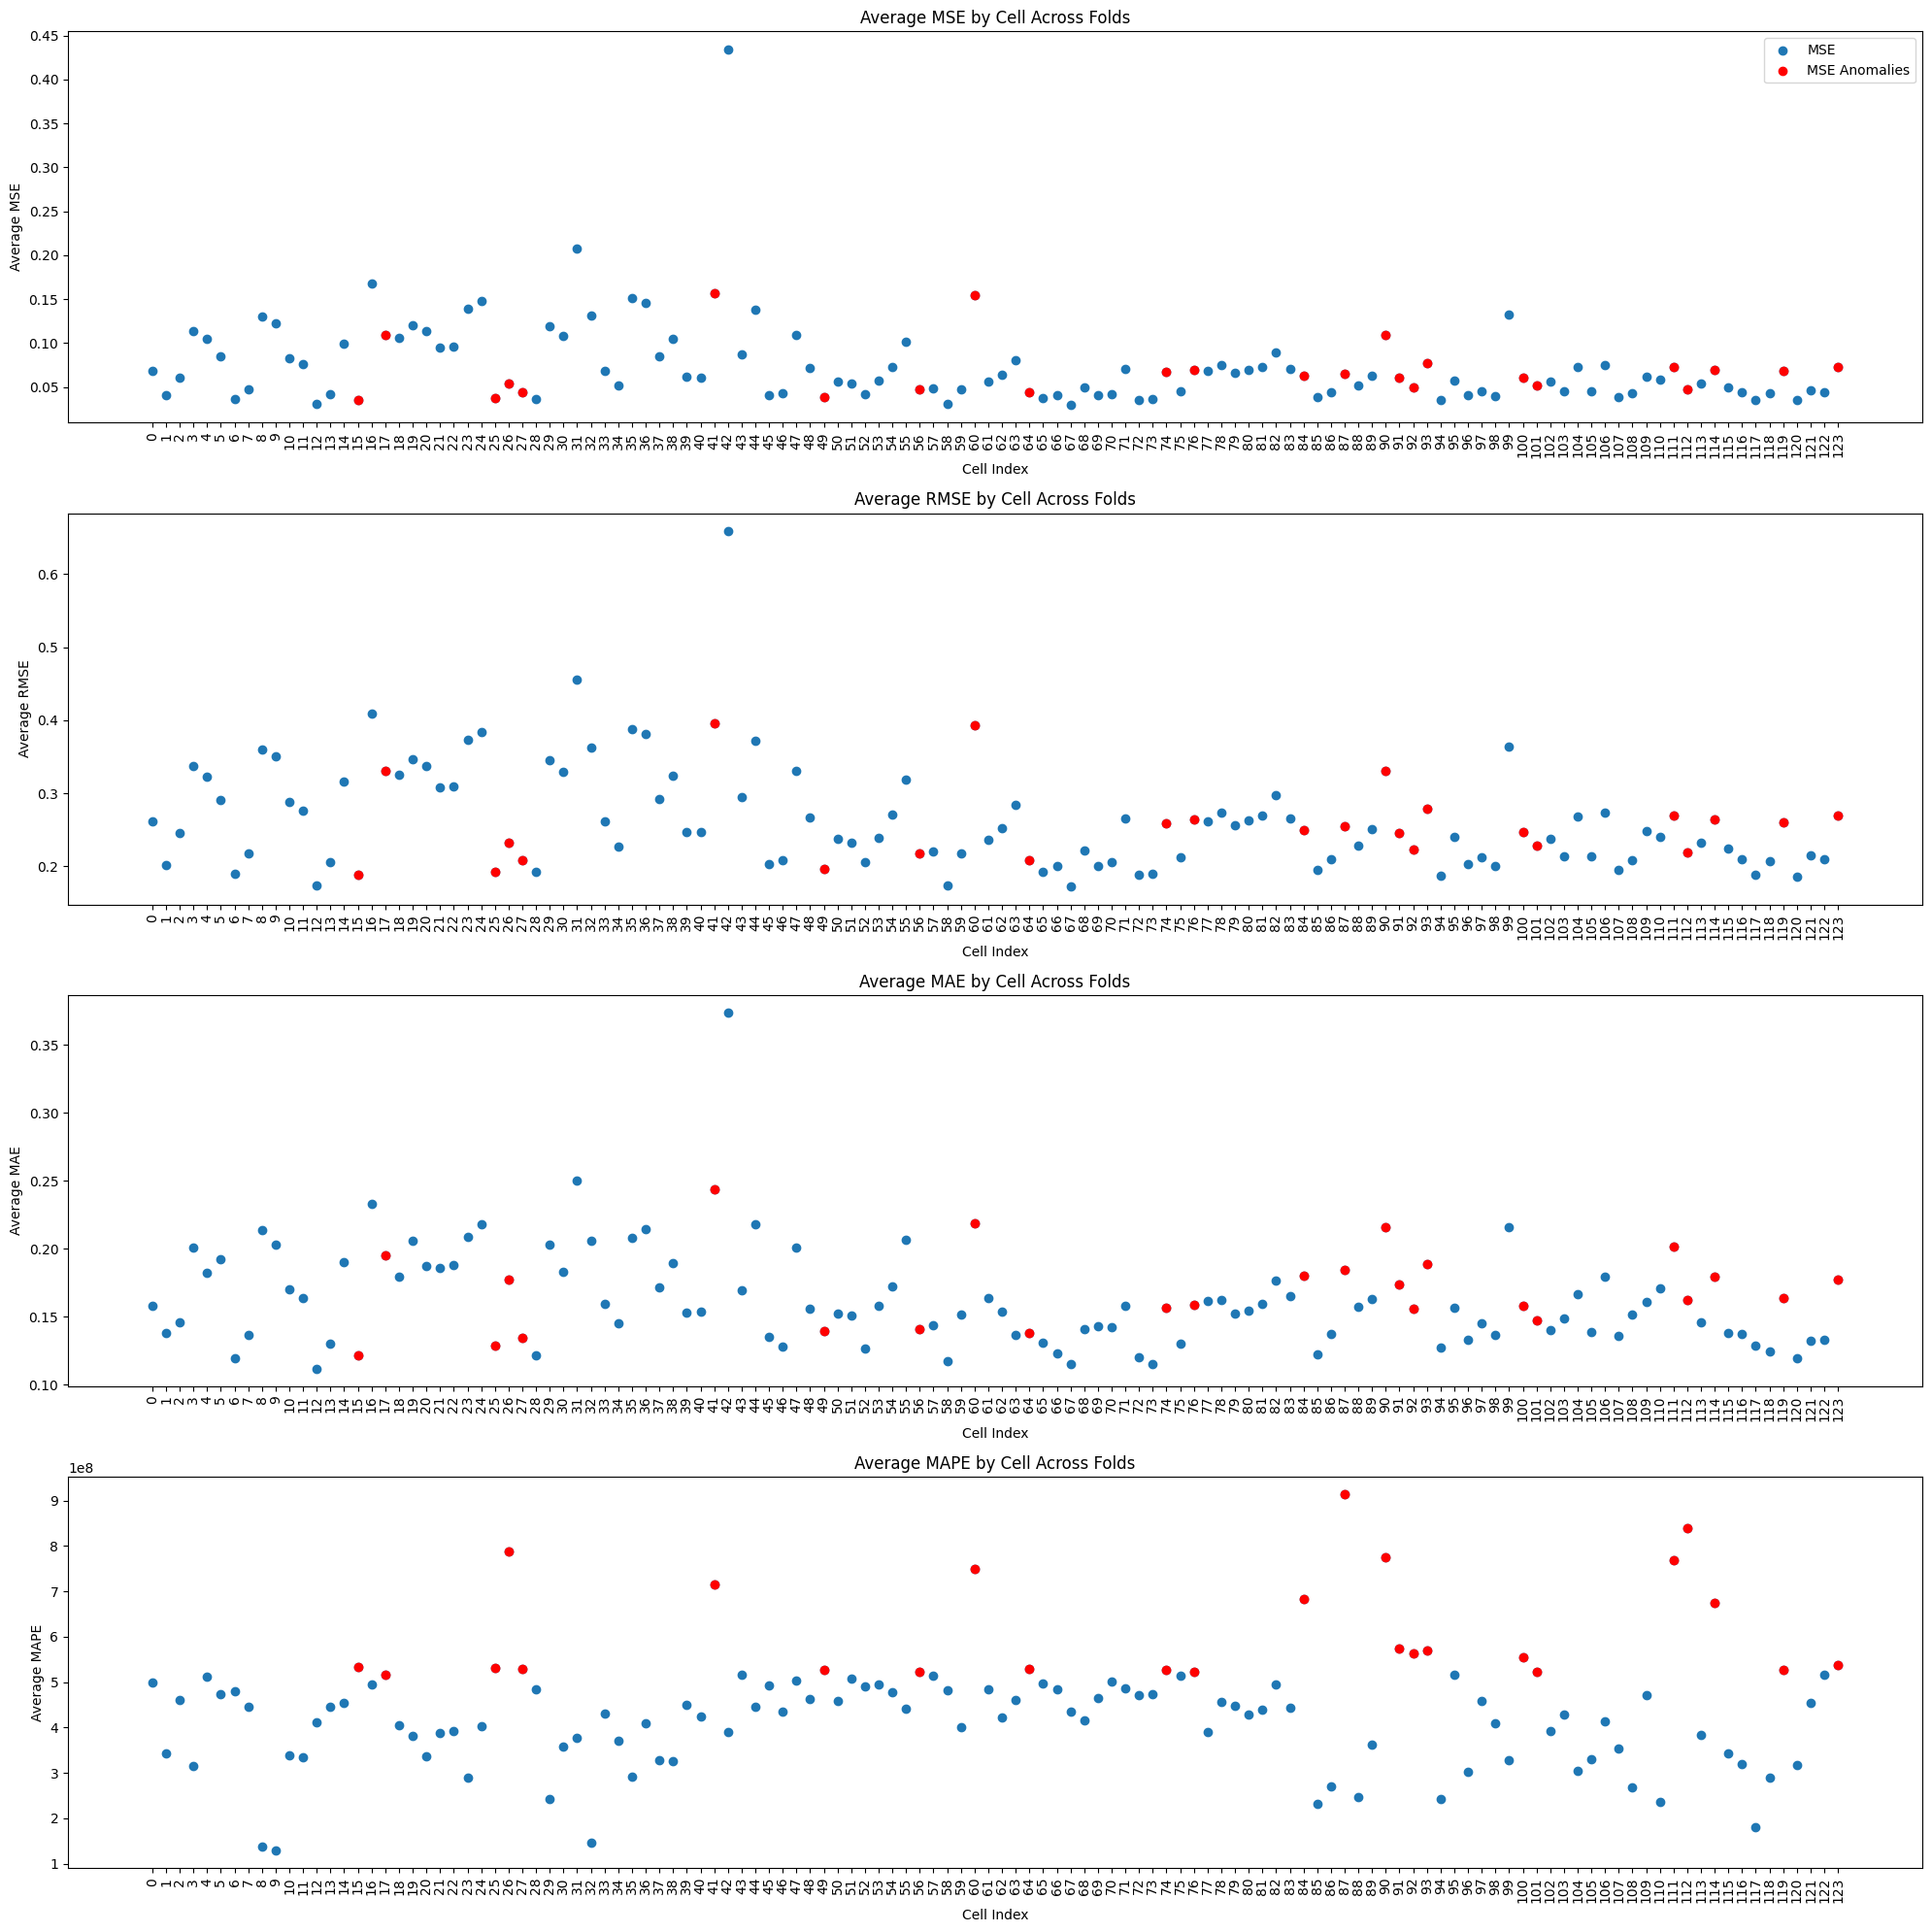

In [31]:
anomalies_cae_sd_by_cells, metric_errors_cae_sd_by_cells = anomaly_detector_cae_sd.detect_anomalies(cae_sd_average_error_metrics_by_cells,
                                                                                                    metric='mape',
                                                                                                    threshold_function=AD.threshold_percentile,
                                                                                                    threshold_value=80)
print(anomalies_cae_sd_by_cells)
anomaly_detector_cae_sd.visual(cae_sd_average_error_metrics_by_cells, anomalies_cae_sd_by_cells)